# SOFIA/FORCAST Galactic Center Combine Fields Notebook

## Preliminary Steps - Select file to use from config.py and load in required packages

In [1]:
#import all required packages
import os
import numpy as np
import re
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.visualization import SqrtStretch, simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.io import fits,ascii
from astropy.wcs import WCS
from astropy import units as u
from astropy.stats import sigma_clipped_stats
from astropy.table import join, vstack, Table
from astropy.coordinates import SkyCoord, search_around_sky, Angle
from astropy.nddata import Cutout2D
from astropy.coordinates import SkyCoord

from photutils.aperture import SkyCircularAperture,SkyCircularAnnulus,aperture_photometry 
from photutils.segmentation import detect_threshold, detect_sources, deblend_sources, SourceCatalog
from photutils.background import Background2D, MedianBackground, SExtractorBackground, MMMBackground
from photutils.utils import calc_total_error
from photutils.morphology import data_properties
from photutils import make_source_mask

In [2]:
#new functions needed for this notebook
from astropy.coordinates.matching import _get_cartesian_kdtree

from regions import read_ds9, write_ds9, CircleSkyRegion

In [3]:
#import configuration for selected file
from config import dpath, dpathalt, ds9path #import additional common paramters

from config import *

In [4]:
from FORCASTphot import CombineFieldResults, remove_duplicates, createNames, findNOTindex, makeDS9reg, performApPhoto, fitshapes, modelSources

In [5]:
#change directory to where data is
try:
    os.chdir(dpath)
except:
    os.chdir(dpathalt)

## Combine data files for each field at 25 um

In [6]:
#create initial master catalog at 25 um
mastercat25=CombineFieldResults('CombCat',25)

#add names to mastercat
mastercat25=createNames(mastercat25)

#print the master catalog
mastercat25

finder,xcentroid,ycentroid,sky_center,aperture_sum_4pix,aperture_sum_err_4pix,aperture_sum_8pix,aperture_sum_err_8pix,aperture_sum_12pix,aperture_sum_err_12pix,pixAnnArea,ann_bkg_med,ann_bkg_mean,ann_bkg_std,texp_med,texp_mean,aper_sum_bkgsub_4pix,aper_4pix_noise,aper_snr_4pix,aper_area_4pix,aper_sum_bkgsub_8pix,aper_8pix_noise,aper_snr_8pix,aper_area_8pix,aper_sum_bkgsub_12pix,aper_12pix_noise,aper_snr_12pix,aper_area_12pix,Field,wv,fit_x_cent,fit_y_cent,fwhm,semimajor_sigma,semiminor_sigma,orientation,elongation,covar_sigx2,covar_sigy2,fit_dist,fit_x0,fit_y0,fit_x0_err,fit_y0_err,fit_amp,fit_gamma,fit_gamma_err,fit_alpha,fit_alpha_err,fit_fwhm,fit_xfwhm,fit_yfwhm,fit_elong,fit_orient,FluxMoffat2D,FluxMoffatErr,ModelSNR,Moffat2DChi2,FluxGauss2D,FluxGauss2DErr,gModelSNR,Gauss2DChi2,FitWarningFlag,"cutouts [25,25]",MoffatChi2RE,GaussChi2RE,BestModel,RA(J2000),DEC(J2000),glon,glat,id,sky_centroid,SourceID
,pix,pix,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,,,,,,pix,pix,pix,deg,,pix2,pix2,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,deg,,,,"deg,deg",
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes7,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,bytes1,float64,float64,float64,float64,int64,object,str17
6,250.49631834015173,66.3426982888925,"266.09497709302605,-29.53686745240035",1.425432384794827,0.10047859269606844,3.9017315444499965,0.20602930127861335,5.766012566480649,0.31385377241813783,842.3886568673647,0.0008851762714127021,0.0013852972926939222,0.008341885231539652,262.2360534667969,225.8635376096834,1.378828481646939,0.1293611021129002,10.658756450942752,52.649291054210295,3.715315931858444,0.2177933886945049,17.05890134741351,210.59716421684118,5.346577438149657,0.32197110552392266,16.605767866807547,473.84361948789274,Field52,25,6.773246447992071,7.900060639557402,6.6587798184981475,3.305867543644594,2.2501731922093837,-79.35223563531638,1.4691613761510742,5.263528164531686,10.72851144652882,4.430459560406114,8.26749219075935,12.42237717119161,1.5460218598277986,2.564374870350843,0.036332404493443105,18.751889905355306,7920.250497701458,7.452160388718075,4106.961195614204,8.992592500996173,6.892220164623115,15.968698778749625,2.316916522881105,0.08436645857469605,4.163994108020895,0.17965836017768663,52.7856241273708,0.4798722527016661,4.190513549471157,0.1767101975337996,51.49673046542383,0.3872041232349465,0,-0.020555345248797017 .. 0.0036593754586277446,1.382437002107054,1.1154745962384152,M,266.09497709302605,-29.53686745240035,359.3464408339575,-0.0829354059850822,1,"266.09497709302605,-29.53686745240035",SFGC359.346-0.083
6,250.60597802727682,73.37081064463712,"266.09495036354866,-29.53536811998432",1.883544003314625,0.08565943133769197,4.592310229445096,0.17996353882181432,6.485609139373599,0.2839276380855657,842.3886568673647,0.00023281047498344593,0.0005204323864080251,0.0071333314333219535,297.2008361816406,298.8330756229812,1.8712866968567525,0.10843001936200176,17.25801312097272,52.649291054210295,4.543281003613607,0.1906223032330868,23.83394244302163,210.59716421684118,6.375293381252747,0.29104350387124067,21.904949935158882,473.84361948789274,Field52,25,6.714298403438999,5.483769332537199,5.978782385990122,2.873531481928331,2.1529985883699347,-83.07794268192497,1.3346648239578836,4.688008674402488,8.204577424753674,1.0241201090633372,7.180857891447031,7.385322683204189,0.7250985711569333,0.7176812071336071,0.040894580749121515,46.380758872513226,1115423.2607771656,45.15066010094185,4085412.545137108,8.860917338727708,2.1258836429851897e-38,2.1258836429851897e-38,1.0,0.0012396364343391628,5.172204457445154,0.18084

In [7]:
#Optional - write 'master' catalogs to fits prior to quality cuts
#mastercat25.write('masterCatComb_FromFields_25um_NoCuts.fits',overwrite=True)

In [8]:
#write out save ds9 region files  - Optional for inspection
#set size of regions 
r = Angle(2.778E-4*3, u.deg) #must be in degrees - current value is r=3"
#write out ds9 files
makeDS9reg('mastercatComb_25um_labelID.reg', mastercat25, r, color='yellow', label="id")
makeDS9reg('mastercatComb_25um_label4pixSNR.reg', mastercat25, r, color='cyan', label="aper_snr_4pix");
makeDS9reg('mastercatComb_25um_label8pixSNR.reg', mastercat25, 3*r, color='green', label="aper_snr_8pix");

In [9]:
#Now lets look at possible duplications that may exist because of overlapping data coverage
print('Number of sources with duplicates included: ', len(mastercat25))
mastercat25,nduplicats=remove_duplicates(mastercat25, 3.0*u.arcsec)
print('Number of sources with duplicates removed: ', len(mastercat25))

Number of sources with duplicates included:  1105
number of likely duplicates:  290
Number of sources with duplicates removed:  961


In [10]:
#write out save ds9 region files - optional for testing
#makeDS9reg('mastercat_noDuplicates_25um_labelID_3as_1st.reg', mastercat25, r, color='magenta', label="id");

In [11]:
#Now lets look at possible duplications that may exist because of overlapping data coverage
print('Number of sources with duplicates included: ', len(mastercat25))
mastercat25,nduplicates=remove_duplicates(mastercat25, 3.0*u.arcsec)
print('Number of sources with duplicates removed: ', len(mastercat25))

Number of sources with duplicates included:  961
number of likely duplicates:  14
Number of sources with duplicates removed:  954


In [12]:
#Now lets look at possible duplications that may exist because of overlapping data coverage
print('Number of sources with duplicates included: ', len(mastercat25))
mastercat25,nduplicates=remove_duplicates(mastercat25, 3.0*u.arcsec)
print('Number of sources with duplicates removed: ', len(mastercat25))

Number of sources with duplicates included:  954
number of likely duplicates:  0
Number of sources with duplicates removed:  954


In [13]:
#write out save ds9 region files - optional for testing
makeDS9reg('mastercat_noDuplicates_25um_labelID.reg', mastercat25, r, color='magenta', label="id");

In [14]:
mastercat25

finder,xcentroid,ycentroid,sky_center,aperture_sum_4pix,aperture_sum_err_4pix,aperture_sum_8pix,aperture_sum_err_8pix,aperture_sum_12pix,aperture_sum_err_12pix,pixAnnArea,ann_bkg_med,ann_bkg_mean,ann_bkg_std,texp_med,texp_mean,aper_sum_bkgsub_4pix,aper_4pix_noise,aper_snr_4pix,aper_area_4pix,aper_sum_bkgsub_8pix,aper_8pix_noise,aper_snr_8pix,aper_area_8pix,aper_sum_bkgsub_12pix,aper_12pix_noise,aper_snr_12pix,aper_area_12pix,Field,wv,fit_x_cent,fit_y_cent,fwhm,semimajor_sigma,semiminor_sigma,orientation,elongation,covar_sigx2,covar_sigy2,fit_dist,fit_x0,fit_y0,fit_x0_err,fit_y0_err,fit_amp,fit_gamma,fit_gamma_err,fit_alpha,fit_alpha_err,fit_fwhm,fit_xfwhm,fit_yfwhm,fit_elong,fit_orient,FluxMoffat2D,FluxMoffatErr,ModelSNR,Moffat2DChi2,FluxGauss2D,FluxGauss2DErr,gModelSNR,Gauss2DChi2,FitWarningFlag,"cutouts [25,25]",MoffatChi2RE,GaussChi2RE,BestModel,RA(J2000),DEC(J2000),glon,glat,id,sky_centroid,SourceID,selfXmatch
,pix,pix,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,,,,,,pix,pix,pix,deg,,pix2,pix2,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,deg,,,,"deg,deg",,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes7,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,bytes1,float64,float64,float64,float64,int64,object,str17,int64
6,250.49631834015173,66.3426982888925,"266.09497709302605,-29.53686745240035",1.425432384794827,0.10047859269606844,3.9017315444499965,0.20602930127861335,5.766012566480649,0.31385377241813783,842.3886568673647,0.0008851762714127021,0.0013852972926939222,0.008341885231539652,262.2360534667969,225.8635376096834,1.378828481646939,0.1293611021129002,10.658756450942752,52.649291054210295,3.715315931858444,0.2177933886945049,17.05890134741351,210.59716421684118,5.346577438149657,0.32197110552392266,16.605767866807547,473.84361948789274,Field52,25,6.773246447992071,7.900060639557402,6.6587798184981475,3.305867543644594,2.2501731922093837,-79.35223563531638,1.4691613761510742,5.263528164531686,10.72851144652882,4.430459560406114,8.26749219075935,12.42237717119161,1.5460218598277986,2.564374870350843,0.036332404493443105,18.751889905355306,7920.250497701458,7.452160388718075,4106.961195614204,8.992592500996173,6.892220164623115,15.968698778749625,2.316916522881105,0.08436645857469605,4.163994108020895,0.17965836017768663,52.7856241273708,0.4798722527016661,4.190513549471157,0.1767101975337996,51.49673046542383,0.3872041232349465,0,-0.020555345248797017 .. 0.0036593754586277446,1.382437002107054,1.1154745962384152,M,266.09497709302605,-29.53686745240035,359.3464408339575,-0.0829354059850822,1,"266.09497709302605,-29.53686745240035",SFGC359.346-0.083,0
6,250.60597802727682,73.37081064463712,"266.09495036354866,-29.53536811998432",1.883544003314625,0.08565943133769197,4.592310229445096,0.17996353882181432,6.485609139373599,0.2839276380855657,842.3886568673647,0.00023281047498344593,0.0005204323864080251,0.0071333314333219535,297.2008361816406,298.8330756229812,1.8712866968567525,0.10843001936200176,17.25801312097272,52.649291054210295,4.543281003613607,0.1906223032330868,23.83394244302163,210.59716421684118,6.375293381252747,0.29104350387124067,21.904949935158882,473.84361948789274,Field52,25,6.714298403438999,5.483769332537199,5.978782385990122,2.873531481928331,2.1529985883699347,-83.07794268192497,1.3346648239578836,4.688008674402488,8.204577424753674,1.0241201090633372,7.180857891447031,7.385322683204189,0.7250985711569333,0.7176812071336071,0.040894580749121515,46.380758872513226,1115423.2607771656,45.15066010094185,4085412.545137108,8.860917338727708,2.1258836429851897e-38,2.1258836429851897e-38,1.0,0.0012396364343391628,5.172

### Quality flags and other cuts

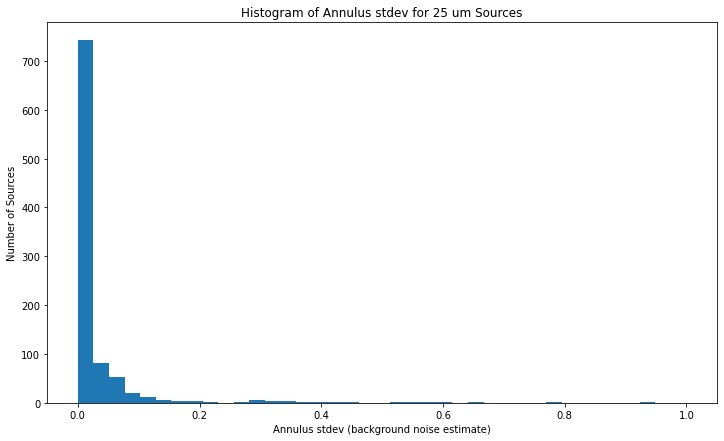

In [15]:
#now lets look at some quality flags...
binlist=np.linspace(0,1.0,40)

plt.figure(figsize=(12,7))
plt.title('Histogram of Annulus stdev for 25 um Sources')
plt.hist(mastercat25['ann_bkg_std'],bins=binlist)
plt.xlabel('Annulus stdev (background noise estimate)')
plt.ylabel('Number of Sources')
#plt.xlim(0,25)
plt.show()

In [16]:
#add quality flags for background noise
bkgmean=np.mean(mastercat25['ann_bkg_std'])
bkgstd=np.std(mastercat25['ann_bkg_std'])

print("average noise measurement for all sources: ", bkgmean, ", standard deviation of noise measurements: ", bkgstd)

bkgstd1sig=mastercat25['ann_bkg_std']>bkgmean+bkgstd
bkgstd2sig=mastercat25['ann_bkg_std']>bkgmean+2*bkgstd
bkgstd3sig=mastercat25['ann_bkg_std']>bkgmean+3*bkgstd


mastercat25['bkg_qflag']=0
mastercat25['bkg_qflag'][bkgstd1sig]=1
mastercat25['bkg_qflag'][bkgstd2sig]=2
mastercat25['bkg_qflag'][bkgstd3sig]=3

average noise measurement for all sources:  0.03722772274488572 , standard deviation of noise measurements:  0.12044679605448143


In [17]:
print('Central distance fit mean: ', np.mean(mastercat25['fit_dist']), '  stdev: ',np.std(mastercat25['fit_dist']))

Central distance fit mean:  3.431594888492637   stdev:  11.743042170829328


In [18]:
sigma_clipped_stats(mastercat25['fit_dist'],sigma=3)

(1.2342352385239268, 0.6436494538469256, 1.2742387694851112)

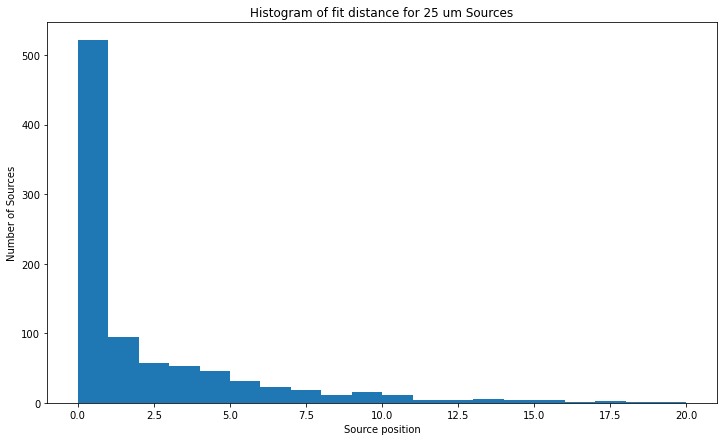

In [19]:
#now lets look at some quality flags...
binlist=np.linspace(0,20.0,21)

plt.figure(figsize=(12,7))
plt.title('Histogram of fit distance for 25 um Sources')
plt.hist(mastercat25['fit_dist'],bins=binlist)
plt.xlabel('Source position')
plt.ylabel('Number of Sources')
#plt.xlim(0,25)
plt.show()

In [20]:
'''
binlist=np.linspace(0,80,40)

plt.figure(figsize=(12,7))
plt.title('Shape Parameters fit Errors')
plt.hist(mastercat25['covar_sigx2'],bins=binlist,label=r'$\sigma_x^2$')
plt.hist(mastercat25['covar_sigy2'],bins=binlist,label=r'$\sigma_y^2$')
plt.xlabel('Error functions from shape fitting')
plt.ylabel('Number of Sources')
plt.legend()
plt.show()
'''

"\nbinlist=np.linspace(0,80,40)\n\nplt.figure(figsize=(12,7))\nplt.title('Shape Parameters fit Errors')\nplt.hist(mastercat25['covar_sigx2'],bins=binlist,label=r'$\\sigma_x^2$')\nplt.hist(mastercat25['covar_sigy2'],bins=binlist,label=r'$\\sigma_y^2$')\nplt.xlabel('Error functions from shape fitting')\nplt.ylabel('Number of Sources')\nplt.legend()\nplt.show()\n"

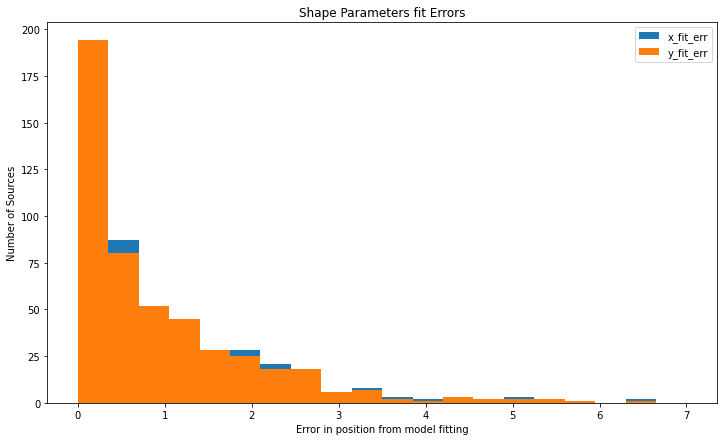

In [21]:
#binlist=np.linspace(0,20,21)
binlist=np.linspace(0,7,21)


plt.figure(figsize=(12,7))
plt.title('Shape Parameters fit Errors')
plt.hist(mastercat25['fit_x0_err'],bins=binlist,label=r'x_fit_err')
plt.hist(mastercat25['fit_y0_err'],bins=binlist,label=r'y_fit_err')
#plt.hist(np.sqrt(mastercat25['fit_y0_err']**2+mastercat25['fit_x0_err']**2),bins=binlist,label=r'posfiterr')
plt.xlabel('Error in position from model fitting')
plt.ylabel('Number of Sources')
plt.legend()
plt.show()


In [22]:
#print('Covar X^2 mean: ', np.mean(mastercat25['covar_sigx2']), '  stdev: ',np.std(mastercat25['covar_sigx2']))
#print('Covar Y^2 mean: ', np.mean(mastercat25['covar_sigy2']), '  stdev: ',np.std(mastercat25['covar_sigy2']))

In [74]:
findmasked=np.ma.getmask(mastercat25['aper_snr_4pix'])

In [75]:
mastercat25[findmasked]

finder,xcentroid,ycentroid,sky_center,aperture_sum_4pix,aperture_sum_err_4pix,aperture_sum_8pix,aperture_sum_err_8pix,aperture_sum_12pix,aperture_sum_err_12pix,pixAnnArea,ann_bkg_med,ann_bkg_mean,ann_bkg_std,texp_med,texp_mean,aper_sum_bkgsub_4pix,aper_4pix_noise,aper_snr_4pix,aper_area_4pix,aper_sum_bkgsub_8pix,aper_8pix_noise,aper_snr_8pix,aper_area_8pix,aper_sum_bkgsub_12pix,aper_12pix_noise,aper_snr_12pix,aper_area_12pix,Field,wv,fit_x_cent,fit_y_cent,fwhm,semimajor_sigma,semiminor_sigma,orientation,elongation,covar_sigx2,covar_sigy2,fit_dist,fit_x0,fit_y0,fit_x0_err,fit_y0_err,fit_amp,fit_gamma,fit_gamma_err,fit_alpha,fit_alpha_err,fit_fwhm,fit_xfwhm,fit_yfwhm,fit_elong,fit_orient,FluxMoffat2D,FluxMoffatErr,ModelSNR,Moffat2DChi2,FluxGauss2D,FluxGauss2DErr,gModelSNR,Gauss2DChi2,FitWarningFlag,"cutouts [25,25]",MoffatChi2RE,GaussChi2RE,BestModel,RA(J2000),DEC(J2000),glon,glat,id,sky_centroid,SourceID,selfXmatch,bkg_qflag
,pix,pix,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,,,,,,pix,pix,pix,deg,,pix2,pix2,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,deg,,,,"deg,deg",,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes7,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,bytes1,float64,float64,float64,float64,int64,object,str17,int64,int32
6,200.87574373188434,16.35963056969328,"266.2539894664017,-29.20026280275724",--,--,--,--,--,--,842.3891778850693,0.0,0.0008969453771558582,0.005742452870565242,79.94081732557927,109.28235129220347,--,--,--,52.64932361781684,--,--,--,210.59729447126736,--,--,--,473.8439125603515,Field43,25,6.079222419413448,6.6762259526351215,6.6845042633439835,3.748287610794584,1.4374214247095531,0.012623282555310304,2.6076469616779,14.049659431558652,2.066180933891559,--,--,--,-1.0,-1.0,--,--,-1.0,--,-1.0,--,2.1258836429851897e-38,2.1258836429851897e-38,1.0,--,--,--,--,--,--,--,--,--,0,-- .. -0.0007871805384557019,--,--,A,266.2539894664017,-29.20026280275724,359.70583601060457,-0.025131588125522693,191,"266.2539894664017,-29.20026280275724",SFGC359.706-0.025,0,0
6,191.9324071739519,16.460446569868992,"266.25617513536656,-29.200241516039608",--,--,--,--,--,--,842.3891778850693,0.0,0.0002591919366172364,0.006724796896472501,115.35780334472656,116.22364007116433,--,--,--,52.64932361781684,--,--,--,210.59729447126736,--,--,--,473.8439125603515,Field43,25,6.714537519569624,6.40940138105408,6.20650486647328,3.4713945326241262,1.3575075221784576,7.461999556079577,2.5571825392565137,11.878417518738372,2.014989155165399,--,--,--,-1.0,-1.0,--,--,-1.0,--,-1.0,--,2.1258836429851897e-38,2.1258836429851897e-38,1.0,--,--,--,--,--,--,--,--,--,0,-- .. 0.009454748001715954,--,--,A,266.25617513536656,-29.200241516039608,359.70685031262246,-0.026747688550592067,193,"266.25617513536656,-29.200241516039608",SFGC359.707-0.027,0,0
6,315.5282849876214,141.08969085876382,"266.4084560132892,-28.902057266059654",--,--,--,--,--,--,842.3886280490058,0.000531278977441778,0.0018195500039985596,0.00846232940792842,151.46685791015625,143.42951560315413,--,--,--,52.64928925306286,--,--,--,210.59715701225144,--,--,--,473.84360327756576,Field31,25,6.684288944770808,6.460845216741216,7.039122204285838,3.9617116855079293,1.4751107535657284,81.70032564857539,2.685704565525969,2.457652670909469,15.413458543465856,--,--,--,-1.0,-1.0,--,--,-1.0,--,-1.0,--,2.1258836429851897e-38,2.1258836429851897e-38,1.0,--,--,--,--,--,--,--,--,--,0,-0.002302280006660388 .. --,--,--,A,266.4084560132892,-28.902057266059654,0.030696674022094875,0.015189725506126014,459,"266.4084560132892,-28.902057266059654",SFGC0.031+0.015,0,0
6,318.18501102075004,156.25101370526798,"266.40780984

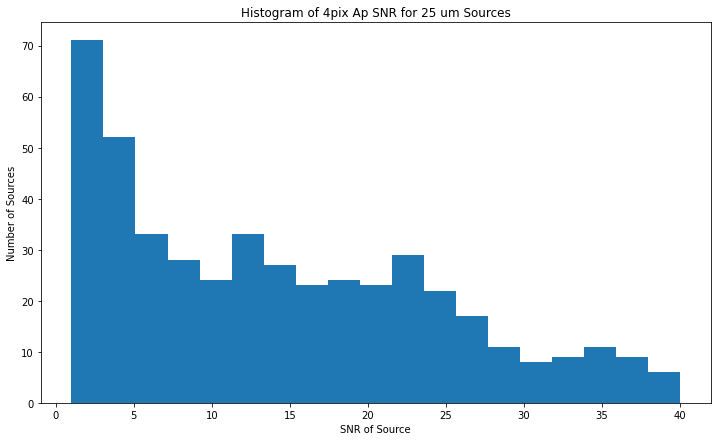

In [23]:
#now lets look at SNR distrobution
binlist=np.linspace(1,40,20)

plt.figure(figsize=(12,7))
plt.title('Histogram of 4pix Ap SNR for 25 um Sources')
plt.hist(mastercat25['aper_snr_4pix'],bins=binlist)
plt.xlabel('SNR of Source')
plt.ylabel('Number of Sources')
#plt.xlim(0,25)
plt.show()


In [24]:
#lets examine SNR cuts...
snrcut4pix=mastercat25['aper_snr_4pix']>=0.5 #max snr in all computed apertures must be gtreq to 5
mcat25snrcut=mastercat25[snrcut4pix] #apply snr cut

#snrcutModel=mastercat25['ModelSNR']>=1.0 #max snr in all computed apertures must be gtreq to 5
#mcat25snrcut=mastercat25[snrcutModel] #apply snr cut


print("Number of Catalog Sources after SNR cut: ", len(mcat25snrcut))

Number of Catalog Sources after SNR cut:  720


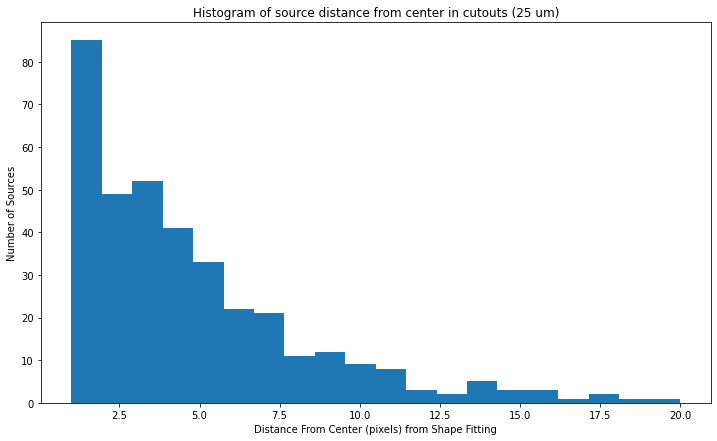

In [25]:
binlist=np.linspace(1,20,21)

plt.figure(figsize=(12,7))
plt.title('Histogram of source distance from center in cutouts (25 um)')
plt.hist(mcat25snrcut['fit_dist'],bins=binlist)
plt.xlabel('Distance From Center (pixels) from Shape Fitting')
plt.ylabel('Number of Sources')
#plt.xlim(0,25)
plt.show()

In [26]:
print('Central distance fit mean: ', np.mean(mcat25snrcut['fit_dist']), '  stdev: ',np.std(mcat25snrcut['fit_dist']))

Central distance fit mean:  4.225380424724819   stdev:  13.332162979858976


In [27]:
#apply quality flags to table
Distmean=np.mean(mcat25snrcut['fit_dist'])
Diststd=np.std(mcat25snrcut['fit_dist'])

distidx1=mcat25snrcut['fit_dist']>4.0
distidx2=mcat25snrcut['fit_dist']>7.0

mcat25snrcut['shape_qflag']=0

mcat25snrcut['shape_qflag'][distidx1]=10
mcat25snrcut['shape_qflag'][distidx2]=mcat25snrcut['shape_qflag'][distidx2]+10

In [28]:
'''
binlist=np.linspace(0,40,40)

plt.figure(figsize=(12,7))
plt.title('Shape Parameters fit Errors')
plt.hist(mcat25snrcut['covar_sigx2'],bins=binlist,label=r'$\sigma_x^2$')
plt.hist(mcat25snrcut['covar_sigy2'],bins=binlist,label=r'$\sigma_y^2$')
plt.xlabel('Error functions from shape fitting')
plt.ylabel('Number of Sources')
plt.legend()
plt.show()
'''

"\nbinlist=np.linspace(0,40,40)\n\nplt.figure(figsize=(12,7))\nplt.title('Shape Parameters fit Errors')\nplt.hist(mcat25snrcut['covar_sigx2'],bins=binlist,label=r'$\\sigma_x^2$')\nplt.hist(mcat25snrcut['covar_sigy2'],bins=binlist,label=r'$\\sigma_y^2$')\nplt.xlabel('Error functions from shape fitting')\nplt.ylabel('Number of Sources')\nplt.legend()\nplt.show()\n"

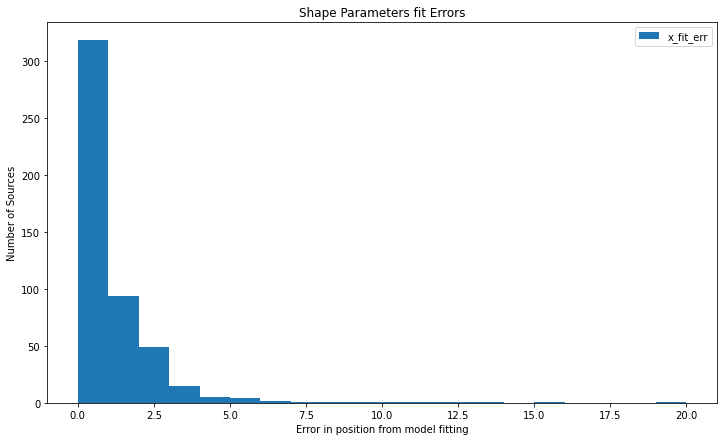

In [29]:
binlist=np.linspace(0,20,21)
#binlist=np.linspace(0,50,51)

plt.figure(figsize=(12,7))
plt.title('Shape Parameters fit Errors')
plt.hist(mastercat25['fit_x0_err'],bins=binlist,label=r'x_fit_err')
#plt.hist(mastercat25['fit_y0_err'],bins=binlist,label=r'y_fit_err')
#plt.hist(np.sqrt(mastercat25['fit_y0_err']**2+mastercat25['fit_x0_err']**2),bins=binlist,label=r'posfiterr')
#plt.hist(mastercat25['fit_gamma_err'],bins=binlist)
plt.xlabel('Error in position from model fitting')
plt.ylabel('Number of Sources')
plt.legend()
plt.show()#fit_gamma_err


In [30]:
#print('Covar X^2 mean: ', np.mean(mcat25snrcut['covar_sigx2']), '  stdev: ',np.std(mcat25snrcut['covar_sigx2']))
#print('Covar Y^2 mean: ', np.mean(mcat25snrcut['covar_sigy2']), '  stdev: ',np.std(mcat25snrcut['covar_sigy2']))

In [31]:
#add quality flags to table
#sigXmean=np.mean(mcat25snrcut['covar_sigx2'])
#sigXstd=np.std(mcat25snrcut['covar_sigx2'])

#sigYmean=np.mean(mcat25snrcut['covar_sigy2'])
#sigYstd=np.std(mcat25snrcut['covar_sigy2'])

#sigXidx=mcat25snrcut['covar_sigx2']>sigXmean+2*sigXstd
#sigYidx=mcat25snrcut['covar_sigy2']>sigYmean+2*sigYstd

#mcat25snrcut['shape_qflag'][sigXidx]=mcat25snrcut['shape_qflag'][sigXidx]+1
#mcat25snrcut['shape_qflag'][sigYidx]=mcat25snrcut['shape_qflag'][sigYidx]+1

In [32]:
#number of sources that are well fit by shape fitting
#np.count_nonzero(mcat25snrcut['shape_qflag']==0)

In [33]:
#number of sources that may not be well fit by the shape fitting
#np.count_nonzero(mcat25snrcut['shape_qflag']>0)

In [34]:
mcat25snrcut

finder,xcentroid,ycentroid,sky_center,aperture_sum_4pix,aperture_sum_err_4pix,aperture_sum_8pix,aperture_sum_err_8pix,aperture_sum_12pix,aperture_sum_err_12pix,pixAnnArea,ann_bkg_med,ann_bkg_mean,ann_bkg_std,texp_med,texp_mean,aper_sum_bkgsub_4pix,aper_4pix_noise,aper_snr_4pix,aper_area_4pix,aper_sum_bkgsub_8pix,aper_8pix_noise,aper_snr_8pix,aper_area_8pix,aper_sum_bkgsub_12pix,aper_12pix_noise,aper_snr_12pix,aper_area_12pix,Field,wv,fit_x_cent,fit_y_cent,fwhm,semimajor_sigma,semiminor_sigma,orientation,elongation,covar_sigx2,covar_sigy2,fit_dist,fit_x0,fit_y0,fit_x0_err,fit_y0_err,fit_amp,fit_gamma,fit_gamma_err,fit_alpha,fit_alpha_err,fit_fwhm,fit_xfwhm,fit_yfwhm,fit_elong,fit_orient,FluxMoffat2D,FluxMoffatErr,ModelSNR,Moffat2DChi2,FluxGauss2D,FluxGauss2DErr,gModelSNR,Gauss2DChi2,FitWarningFlag,"cutouts [25,25]",MoffatChi2RE,GaussChi2RE,BestModel,RA(J2000),DEC(J2000),glon,glat,id,sky_centroid,SourceID,selfXmatch,bkg_qflag,shape_qflag
,pix,pix,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,,,,,,pix,pix,pix,deg,,pix2,pix2,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,deg,,,,"deg,deg",,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes7,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,bytes1,float64,float64,float64,float64,int64,object,str17,int64,int32,int32
6,250.49631834015173,66.3426982888925,"266.09497709302605,-29.53686745240035",1.425432384794827,0.10047859269606844,3.9017315444499965,0.20602930127861335,5.766012566480649,0.31385377241813783,842.3886568673647,0.0008851762714127021,0.0013852972926939222,0.008341885231539652,262.2360534667969,225.8635376096834,1.378828481646939,0.1293611021129002,10.658756450942752,52.649291054210295,3.715315931858444,0.2177933886945049,17.05890134741351,210.59716421684118,5.346577438149657,0.32197110552392266,16.605767866807547,473.84361948789274,Field52,25,6.773246447992071,7.900060639557402,6.6587798184981475,3.305867543644594,2.2501731922093837,-79.35223563531638,1.4691613761510742,5.263528164531686,10.72851144652882,4.430459560406114,8.26749219075935,12.42237717119161,1.5460218598277986,2.564374870350843,0.036332404493443105,18.751889905355306,7920.250497701458,7.452160388718075,4106.961195614204,8.992592500996173,6.892220164623115,15.968698778749625,2.316916522881105,0.08436645857469605,4.163994108020895,0.17965836017768663,52.7856241273708,0.4798722527016661,4.190513549471157,0.1767101975337996,51.49673046542383,0.3872041232349465,0,-0.020555345248797017 .. 0.0036593754586277446,1.382437002107054,1.1154745962384152,M,266.09497709302605,-29.53686745240035,359.3464408339575,-0.0829354059850822,1,"266.09497709302605,-29.53686745240035",SFGC359.346-0.083,0,0,10
6,250.60597802727682,73.37081064463712,"266.09495036354866,-29.53536811998432",1.883544003314625,0.08565943133769197,4.592310229445096,0.17996353882181432,6.485609139373599,0.2839276380855657,842.3886568673647,0.00023281047498344593,0.0005204323864080251,0.0071333314333219535,297.2008361816406,298.8330756229812,1.8712866968567525,0.10843001936200176,17.25801312097272,52.649291054210295,4.543281003613607,0.1906223032330868,23.83394244302163,210.59716421684118,6.375293381252747,0.29104350387124067,21.904949935158882,473.84361948789274,Field52,25,6.714298403438999,5.483769332537199,5.978782385990122,2.873531481928331,2.1529985883699347,-83.07794268192497,1.3346648239578836,4.688008674402488,8.204577424753674,1.0241201090633372,7.180857891447031,7.385322683204189,0.7250985711569333,0.7176812071336071,0.040894580749121515,46.380758872513226,1115423.2607771656,45.15066010094185,4085412.545137108,8.860917338727708,2.1258836429851897e-38,2.12588364298

In [35]:
#makeDS9reg('mastercatComb_4pixSNRselect_25m_NoLabel.reg', mcat25snrcut, r, color='green');

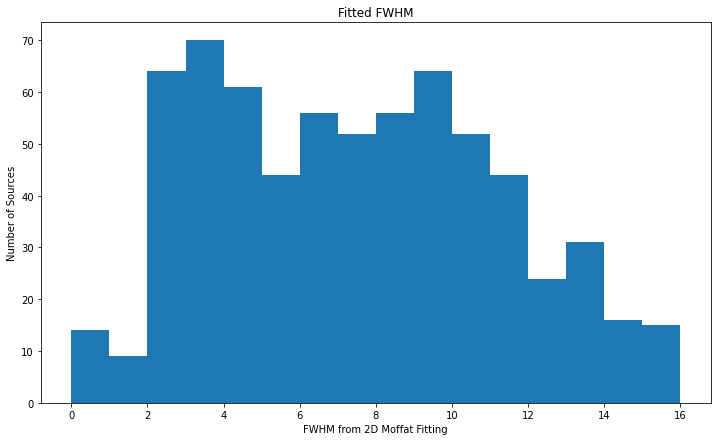

In [36]:
binlist=np.linspace(0,16,17)

plt.figure(figsize=(12,7))
plt.title('Fitted FWHM')
plt.hist(mcat25snrcut['fit_fwhm'],bins=binlist)
plt.xlabel('FWHM from 2D Moffat Fitting')
plt.ylabel('Number of Sources')
plt.show()

In [37]:
# real sources have FWHM that are at least a couple of pixels
update25=mcat25snrcut[mcat25snrcut['fit_fwhm']>=2.0]

In [38]:
update25

finder,xcentroid,ycentroid,sky_center,aperture_sum_4pix,aperture_sum_err_4pix,aperture_sum_8pix,aperture_sum_err_8pix,aperture_sum_12pix,aperture_sum_err_12pix,pixAnnArea,ann_bkg_med,ann_bkg_mean,ann_bkg_std,texp_med,texp_mean,aper_sum_bkgsub_4pix,aper_4pix_noise,aper_snr_4pix,aper_area_4pix,aper_sum_bkgsub_8pix,aper_8pix_noise,aper_snr_8pix,aper_area_8pix,aper_sum_bkgsub_12pix,aper_12pix_noise,aper_snr_12pix,aper_area_12pix,Field,wv,fit_x_cent,fit_y_cent,fwhm,semimajor_sigma,semiminor_sigma,orientation,elongation,covar_sigx2,covar_sigy2,fit_dist,fit_x0,fit_y0,fit_x0_err,fit_y0_err,fit_amp,fit_gamma,fit_gamma_err,fit_alpha,fit_alpha_err,fit_fwhm,fit_xfwhm,fit_yfwhm,fit_elong,fit_orient,FluxMoffat2D,FluxMoffatErr,ModelSNR,Moffat2DChi2,FluxGauss2D,FluxGauss2DErr,gModelSNR,Gauss2DChi2,FitWarningFlag,"cutouts [25,25]",MoffatChi2RE,GaussChi2RE,BestModel,RA(J2000),DEC(J2000),glon,glat,id,sky_centroid,SourceID,selfXmatch,bkg_qflag,shape_qflag
,pix,pix,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,,,,,,pix,pix,pix,deg,,pix2,pix2,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,deg,,,,"deg,deg",,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes7,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,bytes1,float64,float64,float64,float64,int64,object,str17,int64,int32,int32
6,250.49631834015173,66.3426982888925,"266.09497709302605,-29.53686745240035",1.425432384794827,0.10047859269606844,3.9017315444499965,0.20602930127861335,5.766012566480649,0.31385377241813783,842.3886568673647,0.0008851762714127021,0.0013852972926939222,0.008341885231539652,262.2360534667969,225.8635376096834,1.378828481646939,0.1293611021129002,10.658756450942752,52.649291054210295,3.715315931858444,0.2177933886945049,17.05890134741351,210.59716421684118,5.346577438149657,0.32197110552392266,16.605767866807547,473.84361948789274,Field52,25,6.773246447992071,7.900060639557402,6.6587798184981475,3.305867543644594,2.2501731922093837,-79.35223563531638,1.4691613761510742,5.263528164531686,10.72851144652882,4.430459560406114,8.26749219075935,12.42237717119161,1.5460218598277986,2.564374870350843,0.036332404493443105,18.751889905355306,7920.250497701458,7.452160388718075,4106.961195614204,8.992592500996173,6.892220164623115,15.968698778749625,2.316916522881105,0.08436645857469605,4.163994108020895,0.17965836017768663,52.7856241273708,0.4798722527016661,4.190513549471157,0.1767101975337996,51.49673046542383,0.3872041232349465,0,-0.020555345248797017 .. 0.0036593754586277446,1.382437002107054,1.1154745962384152,M,266.09497709302605,-29.53686745240035,359.3464408339575,-0.0829354059850822,1,"266.09497709302605,-29.53686745240035",SFGC359.346-0.083,0,0,10
6,250.60597802727682,73.37081064463712,"266.09495036354866,-29.53536811998432",1.883544003314625,0.08565943133769197,4.592310229445096,0.17996353882181432,6.485609139373599,0.2839276380855657,842.3886568673647,0.00023281047498344593,0.0005204323864080251,0.0071333314333219535,297.2008361816406,298.8330756229812,1.8712866968567525,0.10843001936200176,17.25801312097272,52.649291054210295,4.543281003613607,0.1906223032330868,23.83394244302163,210.59716421684118,6.375293381252747,0.29104350387124067,21.904949935158882,473.84361948789274,Field52,25,6.714298403438999,5.483769332537199,5.978782385990122,2.873531481928331,2.1529985883699347,-83.07794268192497,1.3346648239578836,4.688008674402488,8.204577424753674,1.0241201090633372,7.180857891447031,7.385322683204189,0.7250985711569333,0.7176812071336071,0.040894580749121515,46.380758872513226,1115423.2607771656,45.15066010094185,4085412.545137108,8.860917338727708,2.1258836429851897e-38,2.12588364298

In [39]:
#Optional - write 'master' catalogs to fits prior to quality cuts
update25.write('masterCat_25um_Step3.fits',overwrite=True)

In [40]:
#this is testing related to examining the chi2 values for souces. Some fields appear much lower than they should...
update25.sort("MoffatChi2RE")

In [41]:
update25

finder,xcentroid,ycentroid,sky_center,aperture_sum_4pix,aperture_sum_err_4pix,aperture_sum_8pix,aperture_sum_err_8pix,aperture_sum_12pix,aperture_sum_err_12pix,pixAnnArea,ann_bkg_med,ann_bkg_mean,ann_bkg_std,texp_med,texp_mean,aper_sum_bkgsub_4pix,aper_4pix_noise,aper_snr_4pix,aper_area_4pix,aper_sum_bkgsub_8pix,aper_8pix_noise,aper_snr_8pix,aper_area_8pix,aper_sum_bkgsub_12pix,aper_12pix_noise,aper_snr_12pix,aper_area_12pix,Field,wv,fit_x_cent,fit_y_cent,fwhm,semimajor_sigma,semiminor_sigma,orientation,elongation,covar_sigx2,covar_sigy2,fit_dist,fit_x0,fit_y0,fit_x0_err,fit_y0_err,fit_amp,fit_gamma,fit_gamma_err,fit_alpha,fit_alpha_err,fit_fwhm,fit_xfwhm,fit_yfwhm,fit_elong,fit_orient,FluxMoffat2D,FluxMoffatErr,ModelSNR,Moffat2DChi2,FluxGauss2D,FluxGauss2DErr,gModelSNR,Gauss2DChi2,FitWarningFlag,"cutouts [25,25]",MoffatChi2RE,GaussChi2RE,BestModel,RA(J2000),DEC(J2000),glon,glat,id,sky_centroid,SourceID,selfXmatch,bkg_qflag,shape_qflag
,pix,pix,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,,,,,,pix,pix,pix,deg,,pix2,pix2,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,deg,,,,"deg,deg",,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes7,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,bytes1,float64,float64,float64,float64,int64,object,str17,int64,int32,int32
6,277.1764039645224,134.27023355656343,"266.7705673270532,-28.52832569666687",1.4065682816119722,0.07461398023810575,3.1569901031661427,0.1493591133275218,3.5597942888074816,0.2241869632130997,842.3888423869209,-0.00017324539414073333,-0.0005131207969822956,0.005549158509683954,414.2140197753906,390.20379672628746,1.4156895308006647,0.10035207871992273,14.107226764597257,52.649302649182545,3.1934750999209123,0.1627299056836144,19.624389791817286,210.59721059673018,3.6418855315057126,0.23520009385826066,15.484201012693614,473.8437238426428,Field05,25,6.472096578770441,6.533942225004342,5.460821929638991,2.608336298293689,1.9879841765007291,-77.17133987553328,1.3120508347731974,4.092652286109653,6.662847044904054,1.0657828394367834,8.62848742725416,8.860753515602102,-1.0,-1.0,0.03479257259745016,442.09338036834714,-1.0,5646.417750339634,-1.0,7.523930646165578,6.81628328423583,8.235489114014666,1.2082081642734928,0.24256841999735224,3.4585735818361285,0.13973826594661645,47.86554478141853,0.24238283471262762,3.447777336656125,0.13867634574906476,47.78936326526899,0.22442806651140654,0,-0.0018083330802465547 .. -0.008604387751021687,0.24238283471262762,0.22442806651140654,M,266.7705673270532,-28.52832569666687,0.515039214352041,-0.061900918159179474,1014,"266.7705673270532,-28.52832569666687",SFGC0.515-0.062,0,0,0
6,220.94281158034087,54.869875083146326,"266.13994532929655,-29.497462659145285",1.715561975912642,0.1257954192738104,4.236483909269781,0.2464856768197257,5.475395253276459,0.38092144351938,842.3888604858962,0.00022376225197189237,0.0005084206005837377,0.00775642528419136,174.8240203857422,161.7147843802254,1.7037810491339944,0.14445304958461316,11.794704604945062,52.64930378036851,4.189360202155191,0.25513195533014715,16.420366459913083,210.59721512147405,5.369366912268632,0.3872310787098379,13.866053649820898,473.8437340233166,Field50,25,7.533247434740676,5.966532875081131,6.310186677627901,3.182615827860961,2.057286735069836,-87.24074691751771,1.5469967183514284,4.246093558183452,10.115378659861962,1.3610659055288488,9.027456696446688,7.107344895203123,-1.0,-1.0,0.03921434349362255,300.6953939740204,-1.0,1986.446757149258,-1.0,8.628397491786965,7.2178632643605765,10.5704462066565,1.4644841304835838,0.02757941641395094,4.745111301109295,0.25891300704380904,57.56139336998622,0.24

In [42]:
#write out save ds9 region files - optional for testing
#makeDS9reg('mastercat_25um_ModelSNRupdate.reg', update25, 1.5*r, color='cyan', label="ModelSNR");

(0.0, 2.5)

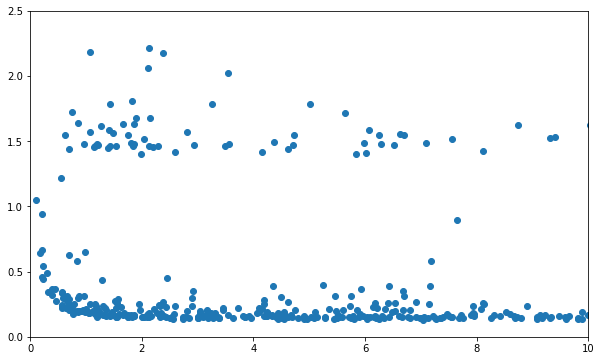

In [48]:
#plt.figure(figsize=(10,6))
#plt.scatter(update25['aper_sum_bkgsub_8pix'],update25['aper_8pix_noise'])
#plt.xlim(0,10)
#plt.ylim(0,2.5)

In [54]:
ExErr=update25[update25['aper_8pix_noise']>1.4]
#set(ExErr['Field'])

{'Field07',
 'Field08',
 'Field09',
 'Field24',
 'Field28',
 'Field35',
 'Field44',
 'Field46',
 'Field47',
 'Field48',
 'Field49',
 'Field50',
 'Field51'}

In [68]:
#makeDS9reg('mastercat_25um_LrgError.reg', ExErr, 1.*r, color='cyan');

## Now for 37 um data

In [46]:
#create initial master catalog at 37 um
mastercat37=CombineFieldResults('CombCat',37)

#add names to mastercat
mastercat37=createNames(mastercat37)

#print the master catalog
mastercat37

finder,xcentroid,ycentroid,sky_center,aperture_sum_5.5pix,aperture_sum_err_5.5pix,aperture_sum_10.5pix,aperture_sum_err_10.5pix,aperture_sum_14pix,aperture_sum_err_14pix,pixAnnArea,ann_bkg_med,ann_bkg_mean,ann_bkg_std,texp_med,texp_mean,aper_sum_bkgsub_5.5pix,aper_5.5pix_noise,aper_snr_5.5pix,aper_area_5.5pix,aper_sum_bkgsub_10.5pix,aper_10.5pix_noise,aper_snr_10.5pix,aper_area_10.5pix,aper_sum_bkgsub_14pix,aper_14pix_noise,aper_snr_14pix,aper_area_14pix,Field,wv,fit_x_cent,fit_y_cent,fwhm,semimajor_sigma,semiminor_sigma,orientation,elongation,covar_sigx2,covar_sigy2,fit_dist,fit_x0,fit_y0,fit_x0_err,fit_y0_err,fit_amp,fit_gamma,fit_gamma_err,fit_alpha,fit_alpha_err,fit_fwhm,fit_xfwhm,fit_yfwhm,fit_elong,fit_orient,FluxMoffat2D,FluxMoffatErr,ModelSNR,Moffat2DChi2,FluxGauss2D,FluxGauss2DErr,gModelSNR,Gauss2DChi2,FitWarningFlag,"cutouts [31,31]",MoffatChi2RE,GaussChi2RE,BestModel,RA(J2000),DEC(J2000),glon,glat,id,sky_centroid,SourceID
,pix,pix,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,,,,,,pix,pix,pix,deg,,pix2,pix2,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,deg,,,,"deg,deg",
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes7,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,bytes1,float64,float64,float64,float64,int64,object,str17
6,240.62999855874736,79.84882164503718,"266.0954459447447,-29.53509122011674",4.196739660650792,0.19983777651406937,9.689087998688564,0.38085019356767086,12.619309884034728,0.5084012944385904,947.6871944902596,0.0007800663553625424,0.0018714687757799412,0.012005648033616057,352.5610656738281,343.83677739731905,4.119091807877005,0.21177493264085548,19.450327555350867,99.54006122684149,9.40609045262873,0.3866189968932914,24.329095383858892,362.7865041408023,12.116203135483913,0.5128156222903634,23.6268214321746,644.9537851392042,Field52,37,8.383068551097487,5.298215281064456,5.8605408503544005,2.752970714793204,2.1929047476227512,-65.53821698529143,1.2553991311193977,5.283798699889057,7.1038802887663515,2.9074975855168304,10.017469251878762,5.9063524586239575,-1.0,-1.0,0.0589365762641477,358.01893629109827,-1.0,2025.8923222147896,-1.0,10.172762697728128,9.552560741970868,10.869631483347584,1.1378761964412258,0.19760787952912912,8.350620605370734,0.30889297716632796,111.67399485914109,0.25288280476554603,8.352388324474866,0.3085618607963815,111.70558859048116,0.24769652529928166,0,-0.02684167025505188 .. 0.015783896846395883,0.617577294923704,0.6049116316870777,M,266.0954459447447,-29.53509122011674,359.3481679327174,-0.0823535656824862,1,"266.0954459447447,-29.53509122011674",SFGC359.348-0.082
5,204.5406252159332,92.06476523812742,"266.1042949324219,-29.53248553795637",0.035082614020147,0.1863575161942756,0.5641115755791402,0.3557176740627466,1.1732301657180173,0.4741895766568357,947.6871944902596,0.0004165020982478318,0.000848325557958499,0.00899211188559196,368.5865783691406,368.55618739865713,-0.006376030340550126,19.44400810699406,-0.00032791749033763524,99.54006122684149,0.4130102353885003,0.6769058084126266,0.6101443217883256,362.7865041408023,0.9046055609346575,0.5914733046531625,1.5294106324293273,644.9537851392042,Field52,37,6.267103792415868,6.604340732262409,8.691643224960119,4.054137699993753,3.288000121610727,30.373383710272506,1.2330102037854274,14.997895757269042,12.24908153295375,0.4900719422428926,7.595051075953774,8.276019704889931,-1.0,-1.0,0.022912026651829925,5.081764294891123,-1.0,12.808794721619126,-1.0,1.8406290890580008,2.4216815589913656,1.4630844604310402,1.655189173616069,-4.057448482667817,0.1574468905959115,0.07069185254129548,0.313239511396259,0.3041060780552425,0.15891142663660476

In [47]:
#Optional - write 'master' catalogs to fits prior to quality cuts
#mastercat37.write('masterCatComb_FromFields_37um_NoCuts.fits',overwrite=True)

In [48]:
#write out save ds9 region files  - Optional for inspection
#set size of regions 
r = Angle(0.00083333, u.deg) #must be in degrees - current value is r=3"
#write out ds9 files
makeDS9reg('mastercatComb_37um_labelID.reg', mastercat37, r, color='yellow', label="id");
makeDS9reg('mastercatComb_37um_label5pixSNR.reg', mastercat37, r, color='cyan', label="aper_snr_5.5pix");

In [49]:
#Now lets look at possible duplications that may exist because of overlapping data coverage

print('Number of sources with duplicates included', len(mastercat37))

mastercat37=remove_duplicates(mastercat37, 5.0*u.arcsec)

print('Number of sources with duplicates removed', len(mastercat37))

Number of sources with duplicates included 940
number of likely duplicates:  343
Number of sources with duplicates removed 746


In [50]:
#write 'master' catalogs to fits - optional for testing
#mastercat37.write('masterCat_FromFields_noDuplicates_37um.fits',overwrite=True)

In [51]:
#write out save ds9 region files - optional for testing
makeDS9reg('mastercat_noDuplicates_37um_labelID.reg', mastercat37, r, color='magenta', label="id");

### Quality Flags and Cuts

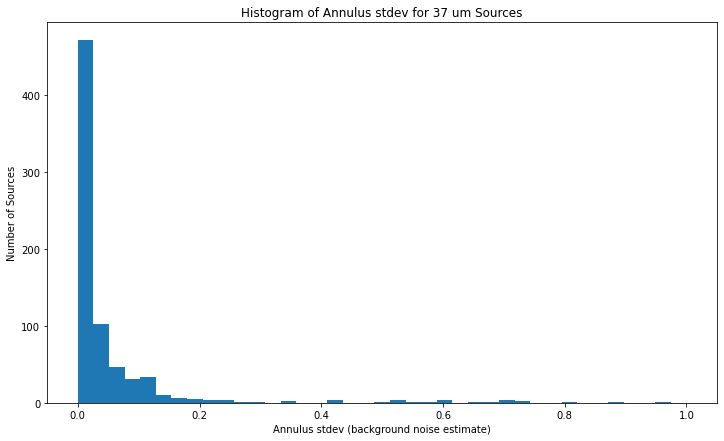

In [52]:
#now lets look at some quality flags...
binlist=np.linspace(0,1.0,40)

plt.figure(figsize=(12,7))
plt.title('Histogram of Annulus stdev for 37 um Sources')
plt.hist(mastercat37['ann_bkg_std'],bins=binlist)
plt.xlabel('Annulus stdev (background noise estimate)')
plt.ylabel('Number of Sources')
#plt.xlim(0,37)
plt.show()

In [53]:
#add quality flags for background noise
bkgmean=np.mean(mastercat37['ann_bkg_std'])
bkgstd=np.std(mastercat37['ann_bkg_std'])

print("average noise measurement for all sources: ", bkgmean, ", standard deviation of noise measurements: ", bkgstd)

bkgstd1sig=mastercat37['ann_bkg_std']>bkgmean+bkgstd
bkgstd2sig=mastercat37['ann_bkg_std']>bkgmean+2*bkgstd
bkgstd3sig=mastercat37['ann_bkg_std']>bkgmean+3*bkgstd


mastercat37['bkg_qflag']=0
mastercat37['bkg_qflag'][bkgstd1sig]=1
mastercat37['bkg_qflag'][bkgstd2sig]=2
mastercat37['bkg_qflag'][bkgstd3sig]=3

average noise measurement for all sources:  0.060903819425641784 , standard deviation of noise measurements:  0.13877972972539254


In [54]:
print('Central distance fit mean: ', np.mean(mastercat37['fit_dist']), '  stdev: ',np.std(mastercat37['fit_dist']))

Central distance fit mean:  4.094224714383777   stdev:  10.873815165094925


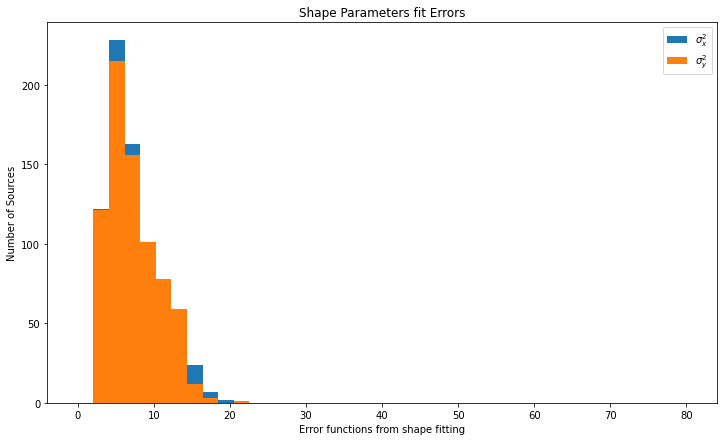

In [55]:
binlist=np.linspace(0,80,40)

plt.figure(figsize=(12,7))
plt.title('Shape Parameters fit Errors')
plt.hist(mastercat37['covar_sigx2'],bins=binlist,label=r'$\sigma_x^2$')
plt.hist(mastercat37['covar_sigy2'],bins=binlist,label=r'$\sigma_y^2$')
plt.xlabel('Error functions from shape fitting')
plt.ylabel('Number of Sources')
plt.legend()
plt.show()

In [56]:
print('Covar X^2 mean: ', np.mean(mastercat37['covar_sigx2']), '  stdev: ',np.std(mastercat37['covar_sigx2']))
print('Covar Y^2 mean: ', np.mean(mastercat37['covar_sigy2']), '  stdev: ',np.std(mastercat37['covar_sigy2']))

Covar X^2 mean:  7.274889652751135   stdev:  3.4240361810973297
Covar Y^2 mean:  7.347183213249922   stdev:  3.2530913018356475


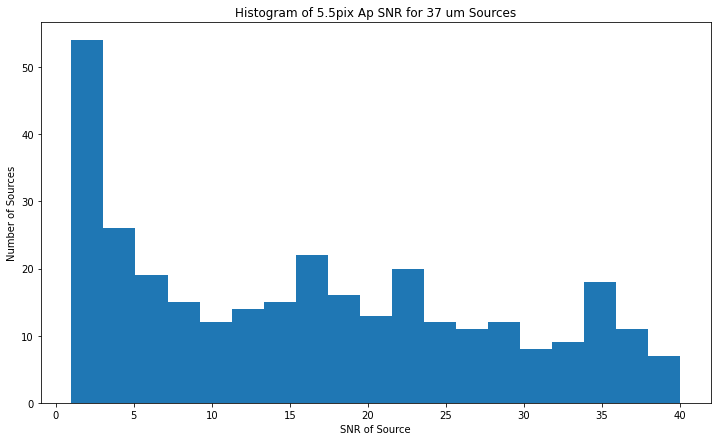

In [57]:
#now lets look at SNR distrobution
binlist=np.linspace(1,40,20)

plt.figure(figsize=(12,7))
plt.title('Histogram of 5.5pix Ap SNR for 37 um Sources')
plt.hist(mastercat37['aper_snr_5.5pix'],bins=binlist)
plt.xlabel('SNR of Source')
plt.ylabel('Number of Sources')
#plt.xlim(0,25)
plt.show()


In [58]:
#lets examine SNR cuts...
snrcut4pix=mastercat37['aper_snr_5.5pix']>=0.5 #max snr in all computed apertures must be gtreq to 5
mcat37snrcut=mastercat37[snrcut4pix] #apply snr cut

print("Number of Catalog Sources after SNR cut: ", len(mcat37snrcut))

Number of Catalog Sources after SNR cut:  596


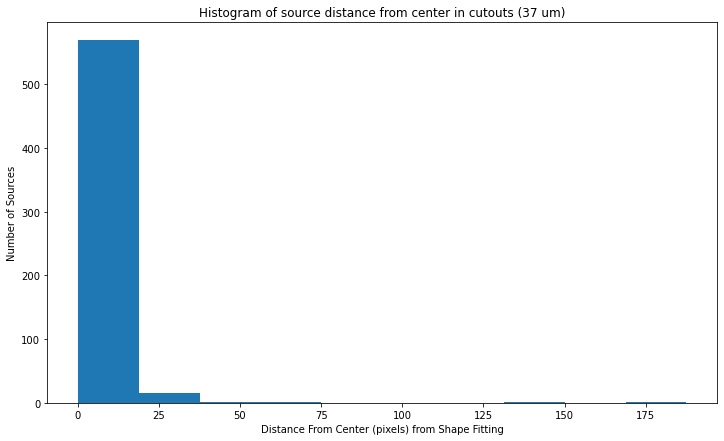

In [59]:
binlist=np.linspace(1,10,20)

plt.figure(figsize=(12,7))
plt.title('Histogram of source distance from center in cutouts (37 um)')
plt.hist(mcat37snrcut['fit_dist'])#,bins=binlist)
plt.xlabel('Distance From Center (pixels) from Shape Fitting')
plt.ylabel('Number of Sources')
#plt.xlim(0,37)
plt.show()

In [60]:
print('Central distance fit mean: ', np.mean(mcat37snrcut['fit_dist']), '  stdev: ',np.std(mcat37snrcut['fit_dist']))

Central distance fit mean:  4.643918116875073   stdev:  11.488577872178658


In [61]:
#apply quality flags to table
Distmean=np.mean(mcat37snrcut['fit_dist'])
Diststd=np.std(mcat37snrcut['fit_dist'])

distidx1=mcat37snrcut['fit_dist']>4.0
distidx2=mcat37snrcut['fit_dist']>7.0

mcat37snrcut['shape_qflag']=0

mcat37snrcut['shape_qflag'][distidx1]=10
mcat37snrcut['shape_qflag'][distidx1]=mcat37snrcut['shape_qflag'][distidx1]+10

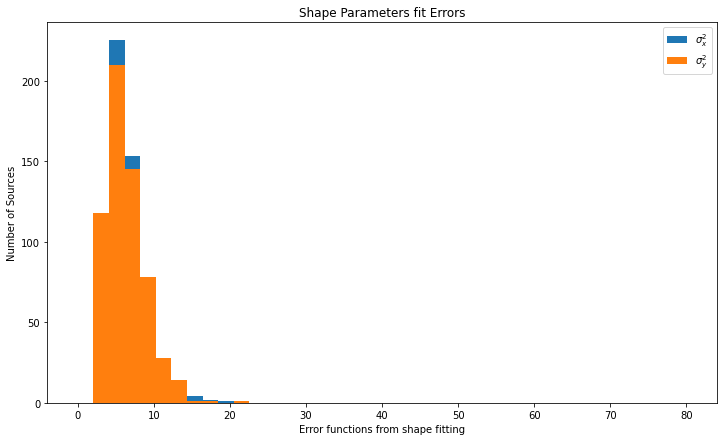

In [62]:
binlist=np.linspace(0,80,40)

plt.figure(figsize=(12,7))
plt.title('Shape Parameters fit Errors')
plt.hist(mcat37snrcut['covar_sigx2'],bins=binlist,label=r'$\sigma_x^2$')
plt.hist(mcat37snrcut['covar_sigy2'],bins=binlist,label=r'$\sigma_y^2$')
plt.xlabel('Error functions from shape fitting')
plt.ylabel('Number of Sources')
plt.legend()
plt.show()

In [63]:
print('Covar X^2 mean: ', np.mean(mcat37snrcut['covar_sigx2']), '  stdev: ',np.std(mcat37snrcut['covar_sigx2']))
print('Covar Y^2 mean: ', np.mean(mcat37snrcut['covar_sigy2']), '  stdev: ',np.std(mcat37snrcut['covar_sigy2']))

Covar X^2 mean:  6.166392538555261   stdev:  2.528088762780516
Covar Y^2 mean:  6.324712609302989   stdev:  2.511170582972961


In [64]:
#add quality flags to table
sigXmean=np.mean(mcat37snrcut['covar_sigx2'])
sigXstd=np.std(mcat37snrcut['covar_sigx2'])

sigYmean=np.mean(mcat37snrcut['covar_sigy2'])
sigYstd=np.std(mcat37snrcut['covar_sigy2'])

sigXidx=mcat37snrcut['covar_sigx2']>sigXmean+2*sigXstd
sigYidx=mcat37snrcut['covar_sigy2']>sigYmean+2*sigYstd

mcat37snrcut['shape_qflag'][sigXidx]=mcat37snrcut['shape_qflag'][sigXidx]+1
mcat37snrcut['shape_qflag'][sigYidx]=mcat37snrcut['shape_qflag'][sigYidx]+1

In [65]:
#number of sources that are well fit by shape fitting
#np.count_nonzero(mcat37snrcut['shape_qflag']==0)

In [66]:
#number of sources that may not be well fit by the shape fitting
#np.count_nonzero(mcat37snrcut['shape_qflag']>0)

In [67]:
mcat37snrcut

finder,xcentroid,ycentroid,sky_center,aperture_sum_5.5pix,aperture_sum_err_5.5pix,aperture_sum_10.5pix,aperture_sum_err_10.5pix,aperture_sum_14pix,aperture_sum_err_14pix,pixAnnArea,ann_bkg_med,ann_bkg_mean,ann_bkg_std,texp_med,texp_mean,aper_sum_bkgsub_5.5pix,aper_5.5pix_noise,aper_snr_5.5pix,aper_area_5.5pix,aper_sum_bkgsub_10.5pix,aper_10.5pix_noise,aper_snr_10.5pix,aper_area_10.5pix,aper_sum_bkgsub_14pix,aper_14pix_noise,aper_snr_14pix,aper_area_14pix,Field,wv,fit_x_cent,fit_y_cent,fwhm,semimajor_sigma,semiminor_sigma,orientation,elongation,covar_sigx2,covar_sigy2,fit_dist,fit_x0,fit_y0,fit_x0_err,fit_y0_err,fit_amp,fit_gamma,fit_gamma_err,fit_alpha,fit_alpha_err,fit_fwhm,fit_xfwhm,fit_yfwhm,fit_elong,fit_orient,FluxMoffat2D,FluxMoffatErr,ModelSNR,Moffat2DChi2,FluxGauss2D,FluxGauss2DErr,gModelSNR,Gauss2DChi2,FitWarningFlag,"cutouts [31,31]",MoffatChi2RE,GaussChi2RE,BestModel,RA(J2000),DEC(J2000),glon,glat,id,sky_centroid,SourceID,selfXmatch,bkg_qflag,shape_qflag
,pix,pix,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,,,,,,pix,pix,pix,deg,,pix2,pix2,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,deg,,,,"deg,deg",,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes7,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,bytes1,float64,float64,float64,float64,int64,object,str17,int64,int32,int32
6,240.62999855874736,79.84882164503718,"266.0954459447447,-29.53509122011674",4.196739660650792,0.19983777651406937,9.689087998688564,0.38085019356767086,12.619309884034728,0.5084012944385904,947.6871944902596,0.0007800663553625424,0.0018714687757799412,0.012005648033616057,352.5610656738281,343.83677739731905,4.119091807877005,0.21177493264085548,19.450327555350867,99.54006122684149,9.40609045262873,0.3866189968932914,24.329095383858892,362.7865041408023,12.116203135483913,0.5128156222903634,23.6268214321746,644.9537851392042,Field52,37,8.383068551097487,5.298215281064456,5.8605408503544005,2.752970714793204,2.1929047476227512,-65.53821698529143,1.2553991311193977,5.283798699889057,7.1038802887663515,2.9074975855168304,10.017469251878762,5.9063524586239575,-1.0,-1.0,0.0589365762641477,358.01893629109827,-1.0,2025.8923222147896,-1.0,10.172762697728128,9.552560741970868,10.869631483347584,1.1378761964412258,0.19760787952912912,8.350620605370734,0.30889297716632796,111.67399485914109,0.25288280476554603,8.352388324474866,0.3085618607963815,111.70558859048116,0.24769652529928166,0,-0.02684167025505188 .. 0.015783896846395883,0.617577294923704,0.6049116316870777,M,266.0954459447447,-29.53509122011674,359.3481679327174,-0.0823535656824862,1,"266.0954459447447,-29.53509122011674",SFGC359.348-0.082,0,0,0
6,232.19490703325073,163.504032152892,"266.09751563203463,-29.517244919747395",4.381759370019283,0.19283683223134895,8.56211062269859,0.36805812264609805,9.136643039093151,0.4907480666776068,947.6871944902596,0.00021946430703576283,0.0005063011929291707,0.012061307942203893,368.5865783691406,368.5384120836905,4.359913879459838,0.20479130663077347,21.289545690142518,99.54006122684149,8.482491933965402,0.37438775433980914,22.65696950725145,362.7865041408023,8.995098703567484,0.49633325302839676,18.123103073758482,644.9537851392042,Field52,37,5.959228542037446,6.088471899594584,6.016967157926574,3.035557466194707,1.9604043903216997,29.217316952364765,1.5484343338450575,7.934789432935818,5.123005071227206,1.5093033042197288,7.821852238331215,6.501247238821228,-1.0,-1.0,0.06148024987781425,319.3721846060059,-1.0,2085.847734729485,-1.0,8.943259143828056,7.265033681881101,10.843159498160617,1.4925133141782008,1.9260521195159668,7.78057973157928,0.28449030908472583,105.23

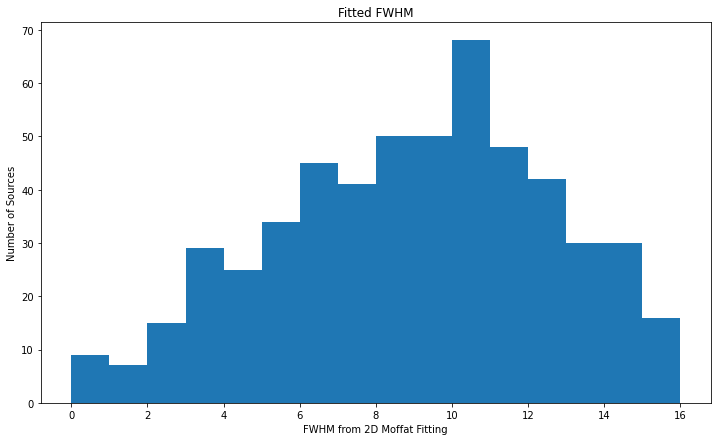

In [68]:
binlist=np.linspace(0,16,17)

plt.figure(figsize=(12,7))
plt.title('Fitted FWHM')
plt.hist(mcat37snrcut['fit_fwhm'],bins=binlist)
plt.xlabel('FWHM from 2D Moffat Fitting')
plt.ylabel('Number of Sources')
plt.show()

In [69]:
# only keep sources with reasonable FWHM
update37=mcat37snrcut[mcat37snrcut['fit_fwhm']>2.0]

In [70]:
update37

finder,xcentroid,ycentroid,sky_center,aperture_sum_5.5pix,aperture_sum_err_5.5pix,aperture_sum_10.5pix,aperture_sum_err_10.5pix,aperture_sum_14pix,aperture_sum_err_14pix,pixAnnArea,ann_bkg_med,ann_bkg_mean,ann_bkg_std,texp_med,texp_mean,aper_sum_bkgsub_5.5pix,aper_5.5pix_noise,aper_snr_5.5pix,aper_area_5.5pix,aper_sum_bkgsub_10.5pix,aper_10.5pix_noise,aper_snr_10.5pix,aper_area_10.5pix,aper_sum_bkgsub_14pix,aper_14pix_noise,aper_snr_14pix,aper_area_14pix,Field,wv,fit_x_cent,fit_y_cent,fwhm,semimajor_sigma,semiminor_sigma,orientation,elongation,covar_sigx2,covar_sigy2,fit_dist,fit_x0,fit_y0,fit_x0_err,fit_y0_err,fit_amp,fit_gamma,fit_gamma_err,fit_alpha,fit_alpha_err,fit_fwhm,fit_xfwhm,fit_yfwhm,fit_elong,fit_orient,FluxMoffat2D,FluxMoffatErr,ModelSNR,Moffat2DChi2,FluxGauss2D,FluxGauss2DErr,gModelSNR,Gauss2DChi2,FitWarningFlag,"cutouts [31,31]",MoffatChi2RE,GaussChi2RE,BestModel,RA(J2000),DEC(J2000),glon,glat,id,sky_centroid,SourceID,selfXmatch,bkg_qflag,shape_qflag
,pix,pix,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,,,,,,pix,pix,pix,deg,,pix2,pix2,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,deg,,,,"deg,deg",,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes7,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,bytes1,float64,float64,float64,float64,int64,object,str17,int64,int32,int32
6,240.62999855874736,79.84882164503718,"266.0954459447447,-29.53509122011674",4.196739660650792,0.19983777651406937,9.689087998688564,0.38085019356767086,12.619309884034728,0.5084012944385904,947.6871944902596,0.0007800663553625424,0.0018714687757799412,0.012005648033616057,352.5610656738281,343.83677739731905,4.119091807877005,0.21177493264085548,19.450327555350867,99.54006122684149,9.40609045262873,0.3866189968932914,24.329095383858892,362.7865041408023,12.116203135483913,0.5128156222903634,23.6268214321746,644.9537851392042,Field52,37,8.383068551097487,5.298215281064456,5.8605408503544005,2.752970714793204,2.1929047476227512,-65.53821698529143,1.2553991311193977,5.283798699889057,7.1038802887663515,2.9074975855168304,10.017469251878762,5.9063524586239575,-1.0,-1.0,0.0589365762641477,358.01893629109827,-1.0,2025.8923222147896,-1.0,10.172762697728128,9.552560741970868,10.869631483347584,1.1378761964412258,0.19760787952912912,8.350620605370734,0.30889297716632796,111.67399485914109,0.25288280476554603,8.352388324474866,0.3085618607963815,111.70558859048116,0.24769652529928166,0,-0.02684167025505188 .. 0.015783896846395883,0.617577294923704,0.6049116316870777,M,266.0954459447447,-29.53509122011674,359.3481679327174,-0.0823535656824862,1,"266.0954459447447,-29.53509122011674",SFGC359.348-0.082,0,0,0
6,232.19490703325073,163.504032152892,"266.09751563203463,-29.517244919747395",4.381759370019283,0.19283683223134895,8.56211062269859,0.36805812264609805,9.136643039093151,0.4907480666776068,947.6871944902596,0.00021946430703576283,0.0005063011929291707,0.012061307942203893,368.5865783691406,368.5384120836905,4.359913879459838,0.20479130663077347,21.289545690142518,99.54006122684149,8.482491933965402,0.37438775433980914,22.65696950725145,362.7865041408023,8.995098703567484,0.49633325302839676,18.123103073758482,644.9537851392042,Field52,37,5.959228542037446,6.088471899594584,6.016967157926574,3.035557466194707,1.9604043903216997,29.217316952364765,1.5484343338450575,7.934789432935818,5.123005071227206,1.5093033042197288,7.821852238331215,6.501247238821228,-1.0,-1.0,0.06148024987781425,319.3721846060059,-1.0,2085.847734729485,-1.0,8.943259143828056,7.265033681881101,10.843159498160617,1.4925133141782008,1.9260521195159668,7.78057973157928,0.28449030908472583,105.23

In [71]:
#Optional - write 'master' catalogs to fits prior to quality cuts
update37.write('masterCat_37um_Step3.fits',overwrite=True)

## Crossmatch the 25 and 37 um catalogs

In [72]:
#get source coordinates from both tables
sources25=mcat25snrcut['sky_centroid']
sources37=mcat37snrcut['sky_centroid']

#crossmatch source lists to look for duplication
idx,rdx, d2d, d3d = sources25.search_around_sky(sources37, 5*u.arcsec) #use larger search radius?
print('Number of crossmatched 25/37 sources found: ', len(idx))

Number of crossmatched 25/37 sources found:  399


In [73]:
matched25=mcat25snrcut[rdx]
matched37=mcat37snrcut[idx]

In [74]:
notrdx=findNOTindex(mcat25snrcut,rdx)
only25=mcat25snrcut[notrdx]

notidx=findNOTindex(mcat37snrcut,idx)
only37=mcat37snrcut[notidx]

In [75]:
#write out catalogs?
#matched25.write('masterCat_step3_25matched.fits',overwrite=True)
#matched37.write('masterCat_step3_37matched.fits',overwrite=True)
#only25.write('masterCat_step3_25only.fits',overwrite=True)
#only37.write('masterCat_step3_37only.fits',overwrite=True)

## Do fixed aperture photometry for non-detections

In [76]:
#run forced photometry at 37 um
wavelength=37

for info in field._registry:
    filename=info.file37
    name=info.name
    m1cut=info.m1cut
    m2lims=info.m2lims
    
    print('\nScript running on field: ', name)
    
    
    try:
        os.chdir(dpath)
    except:
        os.chdir(dpathalt)
    
    #import data - unpack fits file into header, image (data), varance (varmap), and exposure time (tmap)
    hdu=fits.open(filename)
    header=hdu[0].header
    
    #pull the first image plane
    ims=hdu[0].data
    
    #use the first image plane shape to determine how to unpack the rest of the data
    if len(np.shape(ims))==2:
        data=ims
        varmap=hdu[1].data
        tmap=hdu[2].data
    elif len(np.shape(ims))==3:
        data=ims[0]
        varmap=ims[1]
        tmap=ims[2]
        hdu[0].header['NAXIS']=2 #hack to make non-standard WCS work with astropy
    hdu.close()
    
    #define wcs object for header
    wcsmap=WCS(hdu[0].header)
    
    #create pixel error map by taking sqrt of variance map
    errormap=np.sqrt(varmap)
    
    #create initial background model for building source mask
    bkg_estimator = MMMBackground()  #Alternates -  SExtractorBackground() or MedianBackground()
    bkg_data = Background2D(data,(25,25),bkg_estimator=bkg_estimator,edge_method='pad')
    #bkg_rms=bkg_data.background_rms
    bkg=bkg_data.background
    
    tmapnorm=tmap/np.max(tmap) #creating a normalized exposure time map for the mask
    maskTPS=np.where(tmapnorm<0.05,tmapnorm,0).astype('bool')

    #create masked array for the background subtracted data
    data_ma = np.ma.masked_array(data, mask=maskTPS)
    
    mask_3sigma = make_source_mask(data_ma-bkg, nsigma=3, npixels=3, dilate_size=3, filter_fwhm=3)

    data_ma2 = np.ma.masked_array(data, mask=mask_3sigma)
    
    #create updated background model detected sources masked
    bkg_data = Background2D(data_ma2,(25,25),bkg_estimator=bkg_estimator,edge_method='pad')
    bkg_rms=bkg_data.background_rms
    bkg=bkg_data.background

    #create background subtracted image
    data_bkgsub = data - bkg

    
    #specify radii to use with source measurements
    radii = [5.5, 10.5, 14] #aperture radii to use in photoemtry - units are pixels
    r_in = 14  #inner radius for background annulus - units are pixels #12 or 15
    r_out = 22  #outer radius for background annulus - units are pixels #20 or 25
    
    
    
    tab=only25[only25['Field']==name]
    
    if len(tab)>0:
        sources = tab['sky_centroid']
        
        CombPhotTable=performApPhoto(data_bkgsub,errormap,tmap,header,sources,radii,r_in,r_out,plot=False)
        
        CombPhotTable['Field']=name
        CombPhotTable['wv']=wavelength
        
        #merge Tables
        mtComb = CombPhotTable
        
        #add shape parameters to table - depreciated
        mtComb=fitshapes(data_bkgsub,mtComb,cutouts=False,cutsize=31) #optional plot=True for diagnostic plots
        
        mtComb=modelSources(data_bkgsub,errormap,mtComb,header,cutouts=False)
        
        mtComb.write(name+'_'+str(wavelength)+'um_Forced.fits', overwrite=True)
        
    else:
        print('No sources found in Combined Source List')    



Script running on field:  Field01



Script running on field:  Field02


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field03



Script running on field:  Field04


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field05



Script running on field:  Field06



Script running on field:  Field07
No sources found in Combined Source List

Script running on field:  Field08



Script running on field:  Field09



Script running on field:  Field10


C:\Users\mhankins1\Anaconda3\lib\site-packages\astropy\modeling\functional_models.py:2434: RuntimeWarning: invalid value encountered in sqrt
  return 2.0 * np.abs(self.gamma) * np.sqrt(2.0 ** (1.0 / self.alpha) - 1.0)
C:\Users\mhankins1\Anaconda3\lib\site-packages\astropy\modeling\functional_models.py:2434: RuntimeWarning: invalid value encountered in sqrt
  return 2.0 * np.abs(self.gamma) * np.sqrt(2.0 ** (1.0 / self.alpha) - 1.0)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field11


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field12


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
WARNING


Script running on field:  Field13


: FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 58666.373856 from DATE-OBS'. [astropy.wcs.wcs]
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field14



Script running on field:  Field15



Script running on field:  Field16



Script running on field:  Field17


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field18


C:\Users\mhankins1\Anaconda3\lib\site-packages\astropy\modeling\functional_models.py:2434: RuntimeWarning: invalid value encountered in sqrt
  return 2.0 * np.abs(self.gamma) * np.sqrt(2.0 ** (1.0 / self.alpha) - 1.0)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Anaconda3\lib\site-packages\astropy\modeling\functional_models.py:2434: RuntimeWarning: invalid value encountered in sqrt
  return 2.0 * np.abs(self.gamma) * np.sqrt(2.0 ** (1.0 / self.alpha) - 1.0)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid va


Script running on field:  Field19


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field20


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field21


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field22



Script running on field:  Field23



Script running on field:  Field24


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field25


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field26



Script running on field:  Field27



Script running on field:  Field28


C:\Users\mhankins1\Anaconda3\lib\site-packages\astropy\modeling\functional_models.py:2434: RuntimeWarning: invalid value encountered in sqrt
  return 2.0 * np.abs(self.gamma) * np.sqrt(2.0 ** (1.0 / self.alpha) - 1.0)
C:\Users\mhankins1\Anaconda3\lib\site-packages\astropy\modeling\functional_models.py:2434: RuntimeWarning: invalid value encountered in sqrt
  return 2.0 * np.abs(self.gamma) * np.sqrt(2.0 ** (1.0 / self.alpha) - 1.0)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field29


C:\Users\mhankins1\Anaconda3\lib\site-packages\astropy\modeling\functional_models.py:2434: RuntimeWarning: invalid value encountered in sqrt
  return 2.0 * np.abs(self.gamma) * np.sqrt(2.0 ** (1.0 / self.alpha) - 1.0)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Anaconda3\lib\site-packages\astropy\modeling\functional_models.py:2434: RuntimeWarning: invalid value encountered in sqrt
  return 2.0 * np.abs(self.gamma) * np.sqrt(2.0 ** (1.0 / self.alpha) - 1.0)



Script running on field:  Field30



Script running on field:  Field31


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field32


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field33


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field34


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field35
No sources found in Combined Source List

Script running on field:  Field36


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field37


C:\Users\mhankins1\Anaconda3\lib\site-packages\astropy\modeling\functional_models.py:2434: RuntimeWarning: invalid value encountered in sqrt
  return 2.0 * np.abs(self.gamma) * np.sqrt(2.0 ** (1.0 / self.alpha) - 1.0)
C:\Users\mhankins1\Anaconda3\lib\site-packages\astropy\modeling\functional_models.py:2434: RuntimeWarning: invalid value encountered in sqrt
  return 2.0 * np.abs(self.gamma) * np.sqrt(2.0 ** (1.0 / self.alpha) - 1.0)



Script running on field:  Field38



Script running on field:  Field39


C:\Users\mhankins1\Anaconda3\lib\site-packages\astropy\modeling\functional_models.py:2434: RuntimeWarning: invalid value encountered in sqrt
  return 2.0 * np.abs(self.gamma) * np.sqrt(2.0 ** (1.0 / self.alpha) - 1.0)
C:\Users\mhankins1\Anaconda3\lib\site-packages\astropy\modeling\functional_models.py:2434: RuntimeWarning: invalid value encountered in sqrt
  return 2.0 * np.abs(self.gamma) * np.sqrt(2.0 ** (1.0 / self.alpha) - 1.0)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field40



Script running on field:  Field41


C:\Users\mhankins1\Anaconda3\lib\site-packages\astropy\modeling\functional_models.py:2434: RuntimeWarning: invalid value encountered in sqrt
  return 2.0 * np.abs(self.gamma) * np.sqrt(2.0 ** (1.0 / self.alpha) - 1.0)
C:\Users\mhankins1\Anaconda3\lib\site-packages\astropy\modeling\functional_models.py:2434: RuntimeWarning: invalid value encountered in sqrt
  return 2.0 * np.abs(self.gamma) * np.sqrt(2.0 ** (1.0 / self.alpha) - 1.0)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field42


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field43



Script running on field:  Field44


No sources found in Combined Source List

Script running on field:  Field45


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field46



Script running on field:  Field47


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field48



Script running on field:  Field49



Script running on field:  Field50


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field51
No sources found in Combined Source List

Script running on field:  Field52


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)


In [77]:
#combine different out files
Cat37Force=CombineFieldResults('Forced',wavelength)

len(Cat37Force)

260

In [78]:
#get source coordinates from 'finders' and SEG
OGsources=only25['sky_centroid']
FCsources=Cat37Force['sky_centroid']

#crossmatch source lists to look for duplication
idx,rdx, d2d, d3d = OGsources.search_around_sky(FCsources, 1*u.arcsec)
print('Number of crossmatched Finder sources and Seg sources: ', len(idx))

Number of crossmatched Finder sources and Seg sources:  259


In [79]:
matchOG25=only25[rdx]
matchFC37=Cat37Force[idx]

In [80]:
#run forced photometry at 25 um
wavelength=25

for info in field._registry:
    filename=info.file25
    name=info.name
    m1cut=info.m1cut
    m2lims=info.m2lims
    
    print('\nScript running on field: ', name)
    
    
    try:
        os.chdir(dpath)
    except:
        os.chdir(dpathalt)
    
    #import data - unpack fits file into header, image (data), varance (varmap), and exposure time (tmap)
    hdu=fits.open(filename)
    header=hdu[0].header
    
    #pull the first image plane
    ims=hdu[0].data
    
    #use the first image plane shape to determine how to unpack the rest of the data
    if len(np.shape(ims))==2:
        data=ims
        varmap=hdu[1].data
        tmap=hdu[2].data
    elif len(np.shape(ims))==3:
        data=ims[0]
        varmap=ims[1]
        tmap=ims[2]
        hdu[0].header['NAXIS']=2 #hack to make non-standard WCS work with astropy
    hdu.close()
    
    #define wcs object for header
    wcsmap=WCS(hdu[0].header)
    
    #create pixel error map by taking sqrt of variance map
    errormap=np.sqrt(varmap)
    
    #create initial background model for building source mask
    bkg_estimator = MMMBackground()  #Alternates -  SExtractorBackground() or MedianBackground()
    bkg_data = Background2D(data,(25,25),bkg_estimator=bkg_estimator,edge_method='pad')
    #bkg_rms=bkg_data.background_rms
    bkg=bkg_data.background
    
    tmapnorm=tmap/np.max(tmap) #creating a normalized exposure time map for the mask
    maskTPS=np.where(tmapnorm<0.05,tmapnorm,0).astype('bool')

    #create masked array for the background subtracted data
    data_ma = np.ma.masked_array(data, mask=maskTPS)
    
    mask_3sigma = make_source_mask(data_ma-bkg, nsigma=3, npixels=3, dilate_size=3, filter_fwhm=3)

    data_ma2 = np.ma.masked_array(data, mask=mask_3sigma)
    
    #create updated background model detected sources masked
    bkg_data = Background2D(data_ma2,(25,25),bkg_estimator=bkg_estimator,edge_method='pad')
    bkg_rms=bkg_data.background_rms
    bkg=bkg_data.background

    #create background subtracted image
    data_bkgsub = data - bkg

    
    #specify radii to use with source measurements
    radii = [4, 8, 12] #aperture radii to use in photoemtry - units are pixels
    r_in = 12  #inner radius for background annulus - units are pixels #12 or 15
    r_out = 20  #outer radius for background annulus - units are pixels #20 or 25
    
    tab=only37[only37['Field']==name]
    
    #print(len(tab))
    
    if len(tab)>0:
        sources = tab['sky_centroid']
        
        CombPhotTable=performApPhoto(data_bkgsub,errormap,tmap,header,sources,radii,r_in,r_out,plot=False)
        
        CombPhotTable['Field']=name
        CombPhotTable['wv']=wavelength
        
        #merge Tables
        mtComb = CombPhotTable
        
        #add shape parameters to table - depreciated
        mtComb=fitshapes(data_bkgsub,mtComb,cutouts=False) #optional plot=True for diagnostic plots
        
        mtComb=modelSources(data_bkgsub,errormap,mtComb,header,cutouts=False)
        
        mtComb.write(name+'_'+str(wavelength)+'um_Forced.fits', overwrite=True)

    else:
        print('No sources found in Combined Source List')    



Script running on field:  Field01


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field02



Script running on field:  Field03



Script running on field:  Field04



Script running on field:  Field05


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field06


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field07


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field08


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Anaconda3\lib\site-packages\astropy\modeling\functional_models.py:2434: RuntimeWarning: invalid value encountered in sqrt
  return 2.0 * np.abs(self.gamma) * np.sqrt(2.0 ** (1.0 / self.alpha) - 1.0)
C:\Users\mhankins1\Anaconda3\lib\site-packages\astropy\modeling\functional_models.py:2434: RuntimeWarning: invalid value encountered in sqrt
  return 2.0 * np.abs(self.gamma) * np.sqrt(2.0 ** (1.0 / self.alpha) - 1.0)



Script running on field:  Field09



Script running on field:  Field10


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field11


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field12
No sources found in Combined Source List

Script running on field:  Field13


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field14


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field15



Script running on field:  Field16


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field17



Script running on field:  Field18



Script running on field:  Field19


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field20


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field21


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field22


No sources found in Combined Source List

Script running on field:  Field23


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field24
No sources found in Combined Source List

Script running on field:  Field25



Script running on field:  Field26


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field27


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field28
No sources found in Combined Source List

Script running on field:  Field29



Script running on field:  Field30


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field31


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field32



Script running on field:  Field33



Script running on field:  Field34



Script running on field:  Field35



Script running on field:  Field36



Script running on field:  Field37



Script running on field:  Field38



Script running on field:  Field39



Script running on field:  Field40


C:\Users\mhankins1\Anaconda3\lib\site-packages\astropy\modeling\functional_models.py:2434: RuntimeWarning: invalid value encountered in sqrt
  return 2.0 * np.abs(self.gamma) * np.sqrt(2.0 ** (1.0 / self.alpha) - 1.0)
C:\Users\mhankins1\Anaconda3\lib\site-packages\astropy\modeling\functional_models.py:2434: RuntimeWarning: invalid value encountered in sqrt
  return 2.0 * np.abs(self.gamma) * np.sqrt(2.0 ** (1.0 / self.alpha) - 1.0)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
WARNING


Script running on field:  Field41


: FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 58665.616939 from DATE-OBS'. [astropy.wcs.wcs]
C:\Users\mhankins1\Anaconda3\lib\site-packages\astropy\modeling\functional_models.py:2434: RuntimeWarning: invalid value encountered in sqrt
  return 2.0 * np.abs(self.gamma) * np.sqrt(2.0 ** (1.0 / self.alpha) - 1.0)
C:\Users\mhankins1\Anaconda3\lib\site-packages\astropy\modeling\functional_models.py:2434: RuntimeWarning: invalid value encountered in sqrt
  return 2.0 * np.abs(self.gamma) * np.sqrt(2.0 ** (1.0 / self.alpha) - 1.0)



Script running on field:  Field42


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field43



Script running on field:  Field44



Script running on field:  Field45


C:\Users\mhankins1\Anaconda3\lib\site-packages\astropy\modeling\functional_models.py:2434: RuntimeWarning: invalid value encountered in sqrt
  return 2.0 * np.abs(self.gamma) * np.sqrt(2.0 ** (1.0 / self.alpha) - 1.0)
C:\Users\mhankins1\Anaconda3\lib\site-packages\astropy\modeling\functional_models.py:2434: RuntimeWarning: invalid value encountered in sqrt
  return 2.0 * np.abs(self.gamma) * np.sqrt(2.0 ** (1.0 / self.alpha) - 1.0)



Script running on field:  Field46
No sources found in Combined Source List

Script running on field:  Field47



Script running on field:  Field48


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field49



Script running on field:  Field50


C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)
C:\Users\mhankins1\Documents\SFGCphotcode\FORCASTphot.py:44: RuntimeWarning: invalid value encountered in true_divide
  psfmodel = psfmodel / np.sum(psfmodel)



Script running on field:  Field51



Script running on field:  Field52


In [81]:
#combine different out files
Cat25Force=CombineFieldResults('Forced',wavelength)

len(Cat25Force)

218

In [82]:
Cat25Force

xcentroid,ycentroid,aperture_sum_4pix,aperture_sum_err_4pix,aperture_sum_8pix,aperture_sum_err_8pix,aperture_sum_12pix,aperture_sum_err_12pix,pixAnnArea,ann_bkg_med,ann_bkg_mean,ann_bkg_std,texp_med,texp_mean,aper_sum_bkgsub_4pix,aper_4pix_noise,aper_snr_4pix,aper_area_4pix,aper_sum_bkgsub_8pix,aper_8pix_noise,aper_snr_8pix,aper_area_8pix,aper_sum_bkgsub_12pix,aper_12pix_noise,aper_snr_12pix,aper_area_12pix,Field,wv,fit_x_cent,fit_y_cent,fwhm,semimajor_sigma,semiminor_sigma,orientation,elongation,covar_sigx2,covar_sigy2,fit_dist,fit_x0,fit_y0,fit_x0_err,fit_y0_err,fit_amp,fit_gamma,fit_gamma_err,fit_alpha,fit_alpha_err,fit_fwhm,fit_xfwhm,fit_yfwhm,fit_elong,fit_orient,FluxMoffat2D,FluxMoffatErr,ModelSNR,Moffat2DChi2,FluxGauss2D,FluxGauss2DErr,gModelSNR,Gauss2DChi2,FitWarningFlag,"cutouts [25,25]",MoffatChi2RE,GaussChi2RE,BestModel,RA(J2000),DEC(J2000),glon,glat,aperture_sum_4.25pix,aperture_sum_err_4.25pix,aperture_sum_4.5pix,aperture_sum_err_4.5pix,aperture_sum_4.75pix,aperture_sum_err_4.75pix,aperture_sum_5.0pix,aperture_sum_err_5.0pix,aperture_sum_5.25pix,aperture_sum_err_5.25pix,aperture_sum_5.5pix,aperture_sum_err_5.5pix,aperture_sum_10pix,aperture_sum_err_10pix,aper_sum_bkgsub_4.25pix,aper_4.25pix_noise,aper_snr_4.25pix,aper_area_4.25pix,aper_sum_bkgsub_4.5pix,aper_4.5pix_noise,aper_snr_4.5pix,aper_area_4.5pix,aper_sum_bkgsub_4.75pix,aper_4.75pix_noise,aper_snr_4.75pix,aper_area_4.75pix,aper_sum_bkgsub_5.0pix,aper_5.0pix_noise,aper_snr_5.0pix,aper_area_5.0pix,aper_sum_bkgsub_5.25pix,aper_5.25pix_noise,aper_snr_5.25pix,aper_area_5.25pix,aper_sum_bkgsub_5.5pix,aper_5.5pix_noise,aper_snr_5.5pix,aper_area_5.5pix,aper_sum_bkgsub_10pix,aper_10pix_noise,aper_snr_10pix,aper_area_10pix,id,sky_centroid
pix,pix,,,,,,,,,,,,,,,,,,,,,,,,,,,,,pix,pix,pix,deg,,pix2,pix2,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg"
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes7,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,bytes1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,object
146.5429266092628,157.82725672709614,1.9338904742056766,0.0722030763845833,5.965561600020495,0.14438156572056313,11.018018957506621,0.21656301439703288,842.388690423006,0.0045273834074375015,0.008325210353945862,0.012598959724084587,402.0951843261719,401.6652308315532,1.6955269379785438,0.1171444623784909,14.473812108167245,52.64929315143789,5.0121074551119635,0.1623133641166657,30.879203831358087,210.59717260575155,8.872747131462424,0.2273379038582524,39.02889478999805,473.8436383629411,Field52,25,5.692810760391087,7.2277025075453745,7.317249533356344,3.969144396600193,1.8860376421488483,15.24851438591563,2.1044884300813673,14.910415306932512,4.400829921732585,1.1398727166200378,8.000766392820788,9.139872458978104,-1.0,-1.0,0.034509376427248585,424.254158022163,-1.0,2006.652572281648,-1.0,12.112435172670882,1244.4248262835931,7.172772097591732,173.4928712849263,-2.888607912880516,6.1121826823451375,0.1606682928086295,76.74074251610337,1.2345555778451514,6.11717303625389,0.1487775834510029,14.960605146341774,0.38896316743135945,1,0.0 .. 0.0,1.2345555778451514,0.38896316743135945,M,266.1204555935733,-29.517355705298037,359.3746760374975,-0.09162355012722534,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,

In [83]:
#get source coordinates from 'finders' and SEG
OGsources=only37['sky_centroid']
FCsources=Cat25Force['sky_centroid']

#crossmatch source lists to look for duplication
idx,rdx, d2d, d3d = OGsources.search_around_sky(FCsources, 1*u.arcsec)
print('Number of crossmatched Finder sources and Seg sources: ', len(idx))

Number of crossmatched Finder sources and Seg sources:  215


In [84]:
matchOG37=only37[rdx]
matchFC25=Cat25Force[idx]

## Build master catalog from other tables

In [85]:
matched25

finder,xcentroid,ycentroid,sky_center,aperture_sum_4pix,aperture_sum_err_4pix,aperture_sum_8pix,aperture_sum_err_8pix,aperture_sum_12pix,aperture_sum_err_12pix,pixAnnArea,ann_bkg_med,ann_bkg_mean,ann_bkg_std,texp_med,texp_mean,aper_sum_bkgsub_4pix,aper_4pix_noise,aper_snr_4pix,aper_area_4pix,aper_sum_bkgsub_8pix,aper_8pix_noise,aper_snr_8pix,aper_area_8pix,aper_sum_bkgsub_12pix,aper_12pix_noise,aper_snr_12pix,aper_area_12pix,Field,wv,fit_x_cent,fit_y_cent,fwhm,semimajor_sigma,semiminor_sigma,orientation,elongation,covar_sigx2,covar_sigy2,fit_dist,fit_x0,fit_y0,fit_x0_err,fit_y0_err,fit_amp,fit_gamma,fit_gamma_err,fit_alpha,fit_alpha_err,fit_fwhm,fit_xfwhm,fit_yfwhm,fit_elong,fit_orient,FluxMoffat2D,FluxMoffatErr,ModelSNR,Moffat2DChi2,FluxGauss2D,FluxGauss2DErr,gModelSNR,Gauss2DChi2,FitWarningFlag,"cutouts [25,25]",MoffatChi2RE,GaussChi2RE,BestModel,RA(J2000),DEC(J2000),glon,glat,id,sky_centroid,SourceID,selfXmatch,bkg_qflag,shape_qflag
,pix,pix,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,,,,,,pix,pix,pix,deg,,pix2,pix2,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,deg,,,,"deg,deg",,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes7,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,bytes1,float64,float64,float64,float64,int64,object,str17,int64,int32,int32
6,250.60597802727682,73.37081064463712,"266.09495036354866,-29.53536811998432",1.883544003314625,0.08565943133769197,4.592310229445096,0.17996353882181432,6.485609139373599,0.2839276380855657,842.3886568673647,0.00023281047498344593,0.0005204323864080251,0.0071333314333219535,297.2008361816406,298.8330756229812,1.8712866968567525,0.10843001936200176,17.25801312097272,52.649291054210295,4.543281003613607,0.1906223032330868,23.83394244302163,210.59716421684118,6.375293381252747,0.29104350387124067,21.904949935158882,473.84361948789274,Field52,25,6.714298403438999,5.483769332537199,5.978782385990122,2.873531481928331,2.1529985883699347,-83.07794268192497,1.3346648239578836,4.688008674402488,8.204577424753674,1.0241201090633372,7.180857891447031,7.385322683204189,0.7250985711569333,0.7176812071336071,0.040894580749121515,46.380758872513226,1115423.2607771656,45.15066010094185,4085412.545137108,8.860917338727708,2.1258836429851897e-38,2.1258836429851897e-38,1.0,0.0012396364343391628,5.172204457445154,0.18084515335946835,74.44792461573361,0.3988323305606267,--,--,--,--,0,0.0011169264935213651 .. 0.007078889529011731,1.1489736451721457,--,M,266.09495036354866,-29.53536811998432,359.34770634158383,-0.08213102280583723,2,"266.09495036354866,-29.53536811998432",SFGC359.348-0.082,0,0,0
4,239.5935243132066,159.67910405646535,"266.0976520367033,-29.5169558758474",1.764139043025673,0.0721378574154189,4.206197751772709,0.14435021231467793,5.3089080014104715,0.21659547958952255,842.3886568673647,-0.00014474825239916403,-0.0005061142858704007,0.0050131992536510345,402.0951843261719,401.1825653405876,1.7717599358958247,0.0946964428505747,18.709889015488738,52.649291054210295,4.2366813232533165,0.15607276766213954,27.145551313761057,210.59716421684118,5.377496037241839,0.22507472382367852,23.892047698143664,473.84361948789274,Field52,25,6.634573310297923,6.335492963763728,5.047204487581647,2.399647625406882,1.8519160769371097,35.8905178642937,1.2957647785938915,4.957986624396063,4.229915257742961,0.872299372539906,7.659556872662237,7.196878170896845,0.3364234137216114,0.33885816051505985,0.046138229727490564,6.658680616318797,39.082920579203424,1.81525225027448,5.093691864288539,6.974285036303593,7.263577396656305,9.155431620181268,1.260457639564198,1.7801284988190027,4.668271247100928,0.14249132975613,72

In [86]:
t1=Table()
t1['SourceID']=matched25['SourceID']
t1['RA(J2000)']=matched25['RA(J2000)']
t1['DEC(J2000)']=matched25['DEC(J2000)']
t1['25um_Flux_4pix']=matched25['aper_sum_bkgsub_4pix']
t1['25um_Flux_err_4pix']=matched25['aper_4pix_noise']
t1['25um_SNR_4pix']=matched25['aper_snr_4pix']
t1['25um_Flux_8pix']=matched25['aper_sum_bkgsub_8pix']
t1['25um_Flux_err_8pix']=matched25['aper_8pix_noise']
t1['25um_SNR_8pix']=matched25['aper_snr_8pix']
t1['25um_Flux_12pix']=matched25['aper_sum_bkgsub_12pix']
t1['25um_Flux_err_12pix']=matched25['aper_12pix_noise']
t1['25um_SNR_12pix']=matched25['aper_snr_12pix']
t1['25ApRatio8_4']=matched25['aper_sum_bkgsub_8pix']/matched25['aper_sum_bkgsub_4pix']
t1['25ApRatio12_8']=matched25['aper_sum_bkgsub_12pix']/matched25['aper_sum_bkgsub_8pix']
t1['25ApRatio12_8']=matched25['aper_sum_bkgsub_12pix']

t1['25um_Flux_M2D']=matched25['FluxMoffat2D']
t1['25um_Flux_err_M2D']=matched25['FluxMoffatErr']
t1['25um_M2D_chi2']=matched25['Moffat2DChi2']
t1['25um_Flux_G2D']=matched25['FluxGauss2D']
t1['25um_Flux_err_G2D']=matched25['FluxGauss2DErr']
t1['25um_G2D_chi2']=matched25['Gauss2DChi2']
t1['25um_BestModel']=matched25['BestModel']
t1['fwhm25']=np.sqrt(matched25['fit_yfwhm']*matched25['fit_yfwhm'])
t1['elong25']=matched25['fit_elong']

t1['bkg_qflag25']=matched25['bkg_qflag']
t1['shape_qflag25']=matched25['shape_qflag']
t1['cutout25']=matched25['cutouts']

t1['37um_Flux_5.5pix']=matched37['aper_sum_bkgsub_5.5pix']
t1['37um_Flux_err_5.5pix']=matched37['aper_5.5pix_noise']
t1['37um_SNR_5.5pix']=matched37['aper_snr_5.5pix']
t1['37um_Flux_10.5pix']=matched37['aper_sum_bkgsub_10.5pix']
t1['37um_Flux_err_10.5pix']=matched37['aper_10.5pix_noise']
t1['37um_SNR_10.5pix']=matched37['aper_snr_10.5pix']
t1['37um_Flux_14pix']=matched37['aper_sum_bkgsub_14pix']
t1['37um_Flux_err_14pix']=matched37['aper_14pix_noise']
t1['37um_SNR_14pix']=matched37['aper_snr_14pix']
t1['37ApRatio10.5_5.5']=matched37['aper_sum_bkgsub_10.5pix']/matched37['aper_sum_bkgsub_5.5pix']
t1['37ApRatio14_10.5']=matched37['aper_sum_bkgsub_14pix']/matched37['aper_sum_bkgsub_10.5pix']

t1['37um_Flux_M2D']=matched37['FluxMoffat2D']
t1['37um_Flux_err_M2D']=matched37['FluxMoffatErr']
t1['37um_M2D_chi2']=matched37['Moffat2DChi2']
t1['37um_Flux_G2D']=matched37['FluxGauss2D']
t1['37um_Flux_err_G2D']=matched37['FluxGauss2DErr']
t1['37um_G2D_chi2']=matched37['Gauss2DChi2']
t1['37um_BestModel']=matched37['BestModel']
t1['fwhm37']=np.sqrt(matched37['fit_yfwhm']*matched37['fit_yfwhm'])
t1['elong37']=matched37['fit_elong']

t1['bkg_qflag37']=matched37['bkg_qflag']
t1['shape_qflag37']=matched37['shape_qflag']
t1['cutout37']=matched37['cutouts']
t1['sky_centroid']=matched25['sky_centroid']



t2=Table()
t2['SourceID']=matchOG25['SourceID']
t2['RA(J2000)']=matchOG25['RA(J2000)']
t2['DEC(J2000)']=matchOG25['DEC(J2000)']
t2['25um_Flux_4pix']=matchOG25['aper_sum_bkgsub_4pix']
t2['25um_Flux_err_4pix']=matchOG25['aper_4pix_noise']
t2['25um_SNR_4pix']=matchOG25['aper_snr_4pix']
t2['25um_Flux_8pix']=matchOG25['aper_sum_bkgsub_8pix']
t2['25um_Flux_err_8pix']=matchOG25['aper_8pix_noise']
t2['25um_SNR_8pix']=matchOG25['aper_snr_8pix']
t2['25um_Flux_12pix']=matchOG25['aper_sum_bkgsub_12pix']
t2['25um_Flux_err_12pix']=matchOG25['aper_12pix_noise']
t2['25um_SNR_12pix']=matchOG25['aper_snr_12pix']
t2['25ApRatio8_4']=matchOG25['aper_sum_bkgsub_8pix']/matchOG25['aper_sum_bkgsub_4pix']
t2['25ApRatio12_8']=matchOG25['aper_sum_bkgsub_12pix']/matchOG25['aper_sum_bkgsub_8pix']

t2['25um_Flux_M2D']=matchOG25['FluxMoffat2D']
t2['25um_Flux_err_M2D']=matchOG25['FluxMoffatErr']
t2['25um_M2D_chi2']=matchOG25['Moffat2DChi2']
t2['25um_Flux_G2D']=matchOG25['FluxGauss2D']
t2['25um_Flux_err_G2D']=matchOG25['FluxGauss2DErr']
t2['25um_G2D_chi2']=matchOG25['Gauss2DChi2']
t2['25um_BestModel']=matchOG25['BestModel']
t2['fwhm25']=np.sqrt(matchOG25['fit_yfwhm']*matchOG25['fit_yfwhm'])
t2['elong25']=matchOG25['fit_elong']

t2['bkg_qflag25']=matchOG25['bkg_qflag']
t2['shape_qflag25']=matchOG25['shape_qflag']
t2['cutout25']=matchOG25['cutouts']
t2['37um_Flux_5.5pix']=matchFC37['aper_sum_bkgsub_5.5pix']
t2['37um_Flux_err_5.5pix']=matchFC37['aper_5.5pix_noise']
t2['37um_SNR_5.5pix']=matchFC37['aper_snr_5.5pix']
t2['37um_Flux_10.5pix']=matchFC37['aper_sum_bkgsub_10.5pix']
t2['37um_Flux_err_10.5pix']=matchFC37['aper_10.5pix_noise']
t2['37um_SNR_10.5pix']=matchFC37['aper_snr_10.5pix']
t2['37um_Flux_14pix']=matchFC37['aper_sum_bkgsub_14pix']
t2['37um_Flux_err_14pix']=matchFC37['aper_14pix_noise']
t2['37um_SNR_14pix']=matchFC37['aper_snr_14pix']
t2['37ApRatio10.5_5.5']=matchFC37['aper_sum_bkgsub_10.5pix']/matchFC37['aper_sum_bkgsub_5.5pix']
t2['37ApRatio14_10.5']=matchFC37['aper_sum_bkgsub_14pix']/matchFC37['aper_sum_bkgsub_10.5pix']

t2['37um_Flux_M2D']=matchFC37['FluxMoffat2D']
t2['37um_Flux_err_M2D']=matchFC37['FluxMoffatErr']
t2['37um_M2D_chi2']=matchFC37['Moffat2DChi2']
t2['37um_Flux_G2D']=matchFC37['FluxGauss2D']
t2['37um_Flux_err_G2D']=matchFC37['FluxGauss2DErr']
t2['37um_G2D_chi2']=matchFC37['Gauss2DChi2']
t2['37um_BestModel']=matchFC37['BestModel']
t2['fwhm37']=np.sqrt(matchFC37['fit_yfwhm']*matchFC37['fit_yfwhm'])
t2['elong37']=matchFC37['fit_elong']

#t2['bkg_qflag37']=matchFC37['bkg_qflag']
#t2['shape_qflag37']=matchFC37['shape_qflag']
#t2['cutout37']=matchFC37['cutouts']
t2['sky_centroid']=matchOG25['sky_centroid']



t3=Table()
t3['SourceID']=matchOG37['SourceID']
t3['RA(J2000)']=matchOG37['RA(J2000)']
t3['DEC(J2000)']=matchOG37['DEC(J2000)']
t3['25um_Flux_4pix']=matchFC25['aper_sum_bkgsub_4pix']
t3['25um_Flux_err_4pix']=matchFC25['aper_4pix_noise']
t3['25um_SNR_4pix']=matchFC25['aper_snr_4pix']
t3['25um_Flux_8pix']=matchFC25['aper_sum_bkgsub_8pix']
t3['25um_Flux_err_8pix']=matchFC25['aper_8pix_noise']
t3['25um_SNR_8pix']=matchFC25['aper_snr_8pix']
t3['25um_Flux_12pix']=matchFC25['aper_sum_bkgsub_12pix']
t3['25um_Flux_err_12pix']=matchFC25['aper_12pix_noise']
t3['25um_SNR_12pix']=matchFC25['aper_snr_12pix']
t3['25ApRatio8_4']=matchFC25['aper_sum_bkgsub_8pix']/matchFC25['aper_sum_bkgsub_4pix']
t3['25ApRatio12_8']=matchFC25['aper_sum_bkgsub_12pix']/matchFC25['aper_sum_bkgsub_8pix']

t3['25um_Flux_M2D']=matchFC25['FluxMoffat2D']
t3['25um_Flux_err_M2D']=matchFC25['FluxMoffatErr']
t3['25um_M2D_chi2']=matchFC25['Moffat2DChi2']
t3['25um_Flux_G2D']=matchFC25['FluxGauss2D']
t3['25um_Flux_err_G2D']=matchFC25['FluxGauss2DErr']
t3['25um_G2D_chi2']=matchFC25['Gauss2DChi2']
t3['25um_BestModel']=matchFC25['BestModel']
t3['fwhm25']=np.sqrt(matchFC25['fit_yfwhm']*matchFC25['fit_yfwhm'])
t3['elong25']=matchFC25['fit_elong']

#t3['bkg_qflag25']=matchFC25['bkg_qflag']
#t3['shape_qflag25']=matchFC25['shape_qflag']
#t3['cutout25']=matchFC25['cutouts']
t3['37um_Flux_5.5pix']=matchOG37['aper_sum_bkgsub_5.5pix']
t3['37um_Flux_err_5.5pix']=matchOG37['aper_5.5pix_noise']
t3['37um_SNR_5.5pix']=matchOG37['aper_snr_5.5pix']
t3['37um_Flux_10.5pix']=matchOG37['aper_sum_bkgsub_10.5pix']
t3['37um_Flux_err_10.5pix']=matchOG37['aper_10.5pix_noise']
t3['37um_SNR_10.5pix']=matchOG37['aper_snr_10.5pix']
t3['37um_Flux_14pix']=matchOG37['aper_sum_bkgsub_14pix']
t3['37um_Flux_err_14pix']=matchOG37['aper_14pix_noise']
t3['37um_SNR_14pix']=matchOG37['aper_snr_14pix']
t3['37ApRatio10.5_5.5']=matchOG37['aper_sum_bkgsub_10.5pix']/matchOG37['aper_sum_bkgsub_5.5pix']
t3['37ApRatio14_10.5']=matchOG37['aper_sum_bkgsub_14pix']/matchOG37['aper_sum_bkgsub_10.5pix']

t3['37um_Flux_M2D']=matchOG37['FluxMoffat2D']
t3['37um_Flux_err_M2D']=matchOG37['FluxMoffatErr']
t3['37um_M2D_chi2']=matchOG37['Moffat2DChi2']
t3['37um_Flux_G2D']=matchOG37['FluxGauss2D']
t3['37um_Flux_err_G2D']=matchOG37['FluxGauss2DErr']
t3['37um_G2D_chi2']=matchOG37['Gauss2DChi2']
t3['37um_BestModel']=matchOG37['BestModel']
t3['fwhm37']=np.sqrt(matchOG37['fit_yfwhm']*matchOG37['fit_yfwhm'])
t3['elong37']=matchOG37['fit_elong']

t3['bkg_qflag37']=matchOG37['bkg_qflag']
t3['shape_qflag37']=matchOG37['shape_qflag']
t3['cutout37']=matchOG37['cutouts']
t3['sky_centroid']=matchOG37['sky_centroid']

In [87]:
mastercat=vstack((t1,t2,t3))

In [88]:
#change format of columns to save fewer decimal places

if 'sky_centroid' in mastercat.columns:
    skycoords=mastercat['sky_centroid']
    mastercat.remove_columns('sky_centroid')
    

for col in mastercat.colnames:
    if col!='RA(J2000)' and col!='DEC(J2000)' and col!='type' and col!='SourceID' and col!='25um_BestModel' and col!='37um_BestModel': #skip columns that aren't relevant
        mastercat[col].info.format = '%.4G'

        
if 'sky_centroid' not in mastercat.columns:
    mastercat['sky_centroid']=skycoords
        
        
#display catalog
mastercat

SourceID,RA(J2000),DEC(J2000),25um_Flux_4pix,25um_Flux_err_4pix,25um_SNR_4pix,25um_Flux_8pix,25um_Flux_err_8pix,25um_SNR_8pix,25um_Flux_12pix,25um_Flux_err_12pix,25um_SNR_12pix,25ApRatio8_4,25ApRatio12_8,25um_Flux_M2D,25um_Flux_err_M2D,25um_M2D_chi2,25um_Flux_G2D,25um_Flux_err_G2D,25um_G2D_chi2,25um_BestModel,fwhm25,elong25,bkg_qflag25,shape_qflag25,"cutout25 [25,25]",37um_Flux_5.5pix,37um_Flux_err_5.5pix,37um_SNR_5.5pix,37um_Flux_10.5pix,37um_Flux_err_10.5pix,37um_SNR_10.5pix,37um_Flux_14pix,37um_Flux_err_14pix,37um_SNR_14pix,37ApRatio10.5_5.5,37ApRatio14_10.5,37um_Flux_M2D,37um_Flux_err_M2D,37um_M2D_chi2,37um_Flux_G2D,37um_Flux_err_G2D,37um_G2D_chi2,37um_BestModel,fwhm37,elong37,bkg_qflag37,shape_qflag37,"cutout37 [31,31]",sky_centroid
,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg"
str17,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes1,float64,float64,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes1,float64,float64,int32,int32,float64,object
SFGC359.348-0.082,266.09495036354866,-29.53536811998432,1.871,0.1084,17.26,4.543,0.1906,23.83,6.375,0.291,21.9,2.428,6.375,5.172,0.1808,0.3988,--,--,--,M,2.126E-38,1,0,0,0.001117 .. 0.007079,4.119,0.2118,19.45,9.406,0.3866,24.33,12.12,0.5128,23.63,2.284,1.288,8.351,0.3089,0.2529,8.352,0.3086,0.2477,M,10.87,1.138,0,0,-0.02684 .. 0.01578,"266.09495036354866,-29.53536811998432"
SFGC359.365-0.074,266.0976520367033,-29.5169558758474,1.772,0.0947,18.71,4.237,0.1561,27.15,5.377,0.2251,23.89,2.391,5.377,4.668,0.1425,0.346,4.611,0.1403,0.324,M,9.155,1.26,0,0,0.01011 .. -0.002261,4.36,0.2048,21.29,8.482,0.3744,22.66,8.995,0.4963,18.12,1.946,1.06,7.781,0.2845,0.3834,7.743,0.2793,0.3112,M,10.84,1.493,0,0,0.01056 .. 0.01029,"266.0976520367033,-29.5169558758474"
SFGC359.372-0.079,266.1066587461282,-29.513297870753597,3.601,0.09096,39.59,9.078,0.1523,59.59,12.87,0.2198,58.54,2.521,12.87,10.49,0.1474,1.568,10.24,0.1404,0.7087,A,6.733,1.813,0,0,0.005548 .. 0.00861,7.148,0.2026,35.28,16.2,0.3728,43.46,20.03,0.4942,40.53,2.267,1.236,14.14,0.2989,0.7741,14.02,0.2917,0.5219,M,8.066,1.626,0,0,-0.001289 .. -0.00303,"266.1066587461282,-29.513297870753597"
SFGC359.374-0.088,266.11699223318425,-29.51585973844053,1.869,0.09748,19.17,5.283,0.1552,34.04,7.79,0.2229,34.95,2.827,7.79,6.067,0.1505,0.4887,6.061,0.1493,0.4077,M,11.8,1.359,0,0,0.01787 .. -0.0138,6.031,0.2032,29.69,13.13,0.3713,35.35,16.02,0.4918,32.58,2.176,1.221,11.7,0.3006,0.5158,11.69,0.2966,0.3798,M,12.91,1.51,0,0,0.01259 .. -0.02276,"266.11699223318425,-29.51585973844053"
SFGC359.376-0.094,266.12312364597364,-29.517588948087333,1.619,0.1,16.18,4.446,0.1581,28.11,6.653,0.2267,29.35,2.746,6.653,5.393,0.1514,0.9055,5.466,0.1453,0.3945,G,6.851,2.766,0,0,0.002939 .. 0.002277,4.579,0.202,22.67,10.5,0.3687,28.47,13.04,0.4883,26.7,2.292,1.242,9.047,0.2957,0.7499,9.065,0.2779,0.3056,M,6.706,4.084,0,1,-0.01079 .. 0.00555,"266.12312364597364,-29.517588948087333"
SFGC359.403-0.006,266.0539137658435,-29.448565893083515,4.507,0.8611,5.234,5.648,1.718,3.287,5.68,2.572,2.208,1.253,5.68,5.677,0.8511,0.003473,4.93,0.7421,0.004672,M,3.007,1.13,0,0,0.004676 .. -0.005412,3.626,1.53,2.37,4.56,2.944,1.549,4.025,3.941,1.021,1.258,0.8828,4.459,1.46,0.002362,3.839,1.267,0.002848,M,4.068,1.078,0,0,-0.01273 .. 0.01874,"266.0539137658435,-29.448565893083515"
SFGC359.404+0.001,266.04694161813114,-29.444187095468855,2.841,0.883,3.218,5.01,1.786,2.805,5.959,2.704,2.204,1.763,5.959,5.487,1.439,0.002838,4.892,1.299,0.004414,M,6.016,1.194,0,0,0.002236 .. 0.002227,8.259,1.663,4.965,13.81,3.206,4.309,14.98,4.332,3.458,1.672,1.084,13.03,2.231,0.006581,12.35,2.123,0.008056,M,7.798,1.298,0,0,-0.01361 .. 0.0004324,"266.04694161813114,-29.444187095468855"
SFGC359.408-0.031,266.0806822437151,-29.457032377324538,0.8168,0.8103,1.008,1.27,1.617,0.7859,0.9881

In [89]:
#quality flag for photometry  - use this flag to indicate upper limits - Still to do...
mastercat['25ApPhot_qflag']=0
mastercat['25Ap_4pix_UL']=0.
mastercat['25Ap_8pix_UL']=0.
mastercat['25Ap_12pix_UL']=0.

crit25=3.0 #flag any sources with SNR<3

#provide upper limits for 25 um sources
crit1=mastercat['25um_SNR_4pix']<crit25
mastercat['25ApPhot_qflag'][crit1]=100
mastercat['25Ap_4pix_UL'][crit1]=mastercat['25um_Flux_4pix'][crit1]+3*mastercat['25um_Flux_err_4pix'][crit1]


crit2=mastercat['25um_SNR_8pix']<crit25
mastercat['25ApPhot_qflag'][crit2]=mastercat['25ApPhot_qflag'][crit2]+10
mastercat['25Ap_8pix_UL'][crit2]=mastercat['25um_Flux_8pix'][crit2]+3*mastercat['25um_Flux_err_8pix'][crit2]

crit3=mastercat['25um_SNR_12pix']<crit25
mastercat['25ApPhot_qflag'][crit3]=mastercat['25ApPhot_qflag'][crit3]+1
mastercat['25Ap_12pix_UL'][crit3]=mastercat['25um_Flux_12pix'][crit3]+3*mastercat['25um_Flux_err_12pix'][crit3]

In [90]:
#quality flag for photometry
mastercat['37ApPhot_qflag']=0
mastercat['37Ap_5.5pix_UL']=0.
mastercat['37Ap_10.5pix_UL']=0.
mastercat['37Ap_14pix_UL']=0.

crit37=3.0 #flag any sources with SNR<3

#provide upper limits for 37 um sources
crit4=mastercat['37um_SNR_5.5pix']<crit37
mastercat['37ApPhot_qflag'][crit4]=100
mastercat['37Ap_5.5pix_UL'][crit4]=mastercat['37um_Flux_5.5pix'][crit4]+3*mastercat['37um_Flux_err_5.5pix'][crit4]

crit5=mastercat['37um_SNR_10.5pix']<crit37
mastercat['37ApPhot_qflag'][crit5]=mastercat['37ApPhot_qflag'][crit5]+10
mastercat['37Ap_10.5pix_UL'][crit5]=mastercat['37um_Flux_10.5pix'][crit5]+3*mastercat['37um_Flux_err_10.5pix'][crit5]


crit6=mastercat['37um_SNR_14pix']<crit37
mastercat['37ApPhot_qflag'][crit6]=mastercat['37ApPhot_qflag'][crit6]+1
mastercat['37Ap_14pix_UL'][crit6]=mastercat['37um_Flux_14pix'][crit6]+3*mastercat['37um_Flux_err_14pix'][crit6]


In [91]:
#add an ID to table for easy tracking of sources in human vetting
mastercat['id']=np.linspace(1,len(mastercat),len(mastercat),dtype=np.int64)

In [92]:
mastercat

SourceID,RA(J2000),DEC(J2000),25um_Flux_4pix,25um_Flux_err_4pix,25um_SNR_4pix,25um_Flux_8pix,25um_Flux_err_8pix,25um_SNR_8pix,25um_Flux_12pix,25um_Flux_err_12pix,25um_SNR_12pix,25ApRatio8_4,25ApRatio12_8,25um_Flux_M2D,25um_Flux_err_M2D,25um_M2D_chi2,25um_Flux_G2D,25um_Flux_err_G2D,25um_G2D_chi2,25um_BestModel,fwhm25,elong25,bkg_qflag25,shape_qflag25,"cutout25 [25,25]",37um_Flux_5.5pix,37um_Flux_err_5.5pix,37um_SNR_5.5pix,37um_Flux_10.5pix,37um_Flux_err_10.5pix,37um_SNR_10.5pix,37um_Flux_14pix,37um_Flux_err_14pix,37um_SNR_14pix,37ApRatio10.5_5.5,37ApRatio14_10.5,37um_Flux_M2D,37um_Flux_err_M2D,37um_M2D_chi2,37um_Flux_G2D,37um_Flux_err_G2D,37um_G2D_chi2,37um_BestModel,fwhm37,elong37,bkg_qflag37,shape_qflag37,"cutout37 [31,31]",sky_centroid,25ApPhot_qflag,25Ap_4pix_UL,25Ap_8pix_UL,25Ap_12pix_UL,37ApPhot_qflag,37Ap_5.5pix_UL,37Ap_10.5pix_UL,37Ap_14pix_UL,id
,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg",,,,,,,,,
str17,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes1,float64,float64,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes1,float64,float64,int32,int32,float64,object,int32,float64,float64,float64,int32,float64,float64,float64,int64
SFGC359.348-0.082,266.09495036354866,-29.53536811998432,1.871,0.1084,17.26,4.543,0.1906,23.83,6.375,0.291,21.9,2.428,6.375,5.172,0.1808,0.3988,--,--,--,M,2.126E-38,1,0,0,0.001117 .. 0.007079,4.119,0.2118,19.45,9.406,0.3866,24.33,12.12,0.5128,23.63,2.284,1.288,8.351,0.3089,0.2529,8.352,0.3086,0.2477,M,10.87,1.138,0,0,-0.02684 .. 0.01578,"266.09495036354866,-29.53536811998432",0,0.0,0.0,0.0,0,0.0,0.0,0.0,1
SFGC359.365-0.074,266.0976520367033,-29.5169558758474,1.772,0.0947,18.71,4.237,0.1561,27.15,5.377,0.2251,23.89,2.391,5.377,4.668,0.1425,0.346,4.611,0.1403,0.324,M,9.155,1.26,0,0,0.01011 .. -0.002261,4.36,0.2048,21.29,8.482,0.3744,22.66,8.995,0.4963,18.12,1.946,1.06,7.781,0.2845,0.3834,7.743,0.2793,0.3112,M,10.84,1.493,0,0,0.01056 .. 0.01029,"266.0976520367033,-29.5169558758474",0,0.0,0.0,0.0,0,0.0,0.0,0.0,2
SFGC359.372-0.079,266.1066587461282,-29.513297870753597,3.601,0.09096,39.59,9.078,0.1523,59.59,12.87,0.2198,58.54,2.521,12.87,10.49,0.1474,1.568,10.24,0.1404,0.7087,A,6.733,1.813,0,0,0.005548 .. 0.00861,7.148,0.2026,35.28,16.2,0.3728,43.46,20.03,0.4942,40.53,2.267,1.236,14.14,0.2989,0.7741,14.02,0.2917,0.5219,M,8.066,1.626,0,0,-0.001289 .. -0.00303,"266.1066587461282,-29.513297870753597",0,0.0,0.0,0.0,0,0.0,0.0,0.0,3
SFGC359.374-0.088,266.11699223318425,-29.51585973844053,1.869,0.09748,19.17,5.283,0.1552,34.04,7.79,0.2229,34.95,2.827,7.79,6.067,0.1505,0.4887,6.061,0.1493,0.4077,M,11.8,1.359,0,0,0.01787 .. -0.0138,6.031,0.2032,29.69,13.13,0.3713,35.35,16.02,0.4918,32.58,2.176,1.221,11.7,0.3006,0.5158,11.69,0.2966,0.3798,M,12.91,1.51,0,0,0.01259 .. -0.02276,"266.11699223318425,-29.51585973844053",0,0.0,0.0,0.0,0,0.0,0.0,0.0,4
SFGC359.376-0.094,266.12312364597364,-29.517588948087333,1.619,0.1,16.18,4.446,0.1581,28.11,6.653,0.2267,29.35,2.746,6.653,5.393,0.1514,0.9055,5.466,0.1453,0.3945,G,6.851,2.766,0,0,0.002939 .. 0.002277,4.579,0.202,22.67,10.5,0.3687,28.47,13.04,0.4883,26.7,2.292,1.242,9.047,0.2957,0.7499,9.065,0.2779,0.3056,M,6.706,4.084,0,1,-0.01079 .. 0.00555,"266.12312364597364,-29.517588948087333",0,0.0,0.0,0.0,0,0.0,0.0,0.0,5
SFGC359.403-0.006,266.0539137658435,-29.448565893083515,4.507,0.8611,5.234,5.648,1.718,3.287,5.68,2.572,2.208,1.253,5.68,5.677,0.8511,0.003473,4.93,0.7421,0.004672,M,3.007,1.13,0,0,0.004676 .. -0.005412,3.626,1.53,2.37,4.56,2.944,1.549,4.025,3.941,1.021,1.258,0.8828,4.459,1.46,0.002362,3.839,1.267,0.002848,M,4.068,1.078,0,0,-0.01273 .. 0.01874,"266.0539137658435,-29.448565893083515",1,0.0,0.0,13.3956767537629,111,8.215195435625468,13.391661741362313,15.847084846449507,6
SFGC359.404+0.001,266.04694161813114,-29.444187095468855,2.8

In [93]:
#write out final catalog
mastercat.write('masterCat_step3_combined.fits',overwrite=True)

In [118]:
mastercat[9]

SourceID,RA(J2000),DEC(J2000),25um_Flux_4pix,25um_Flux_err_4pix,25um_SNR_4pix,25um_Flux_8pix,25um_Flux_err_8pix,25um_SNR_8pix,25um_Flux_12pix,25um_Flux_err_12pix,25um_SNR_12pix,25ApRatio8_4,25ApRatio12_8,25um_Flux_M2D,25um_Flux_err_M2D,25um_M2D_chi2,25um_Flux_G2D,25um_Flux_err_G2D,25um_G2D_chi2,25um_BestModel,fwhm25,elong25,bkg_qflag25,shape_qflag25,"cutout25 [25,25]",37um_Flux_5.5pix,37um_Flux_err_5.5pix,37um_SNR_5.5pix,37um_Flux_10.5pix,37um_Flux_err_10.5pix,37um_SNR_10.5pix,37um_Flux_14pix,37um_Flux_err_14pix,37um_SNR_14pix,37ApRatio10.5_5.5,37ApRatio14_10.5,37um_Flux_M2D,37um_Flux_err_M2D,37um_M2D_chi2,37um_Flux_G2D,37um_Flux_err_G2D,37um_G2D_chi2,37um_BestModel,fwhm37,elong37,bkg_qflag37,shape_qflag37,"cutout37 [31,31]",sky_centroid,25ApPhot_qflag,25Ap_4pix_UL,25Ap_8pix_UL,25Ap_12pix_UL,37ApPhot_qflag,37Ap_5.5pix_UL,37Ap_10.5pix_UL,37Ap_14pix_UL,id
,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg",,,,,,,,,
str17,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes1,float64,float64,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes1,float64,float64,int32,int32,float64,object,int32,float64,float64,float64,int32,float64,float64,float64,int64
SFGC359.410+0.032,266.02006908793686,-29.42252156100146,2.435,0.7414,3.284,6.285,1.479,4.248,9.391,2.227,4.217,2.581,9.391,7.422,1.568,0.004048,7.34,1.554,0.004385,M,8.896,1.196,0,0,-0.004579 .. 0.01232,6.227,1.503,4.142,16.92,2.902,5.831,23.58,3.897,6.051,2.717,1.394,14.25,2.484,0.006078,14.23,2.483,0.006015,M,15.78,1.314,0,0,0.01089 .. -0.003741,"266.02006908793686,-29.42252156100146",0,0.0,0.0,0.0,0,0.0,0.0,0.0,10


In [119]:
mastercat[10]

SourceID,RA(J2000),DEC(J2000),25um_Flux_4pix,25um_Flux_err_4pix,25um_SNR_4pix,25um_Flux_8pix,25um_Flux_err_8pix,25um_SNR_8pix,25um_Flux_12pix,25um_Flux_err_12pix,25um_SNR_12pix,25ApRatio8_4,25ApRatio12_8,25um_Flux_M2D,25um_Flux_err_M2D,25um_M2D_chi2,25um_Flux_G2D,25um_Flux_err_G2D,25um_G2D_chi2,25um_BestModel,fwhm25,elong25,bkg_qflag25,shape_qflag25,"cutout25 [25,25]",37um_Flux_5.5pix,37um_Flux_err_5.5pix,37um_SNR_5.5pix,37um_Flux_10.5pix,37um_Flux_err_10.5pix,37um_SNR_10.5pix,37um_Flux_14pix,37um_Flux_err_14pix,37um_SNR_14pix,37ApRatio10.5_5.5,37ApRatio14_10.5,37um_Flux_M2D,37um_Flux_err_M2D,37um_M2D_chi2,37um_Flux_G2D,37um_Flux_err_G2D,37um_G2D_chi2,37um_BestModel,fwhm37,elong37,bkg_qflag37,shape_qflag37,"cutout37 [31,31]",sky_centroid,25ApPhot_qflag,25Ap_4pix_UL,25Ap_8pix_UL,25Ap_12pix_UL,37ApPhot_qflag,37Ap_5.5pix_UL,37Ap_10.5pix_UL,37Ap_14pix_UL,id
,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg",,,,,,,,,
str17,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes1,float64,float64,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes1,float64,float64,int32,int32,float64,object,int32,float64,float64,float64,int32,float64,float64,float64,int64
SFGC359.410+0.032,266.02006908793686,-29.42252156100146,2.435,0.7414,3.284,6.285,1.479,4.248,9.391,2.227,4.217,2.581,9.391,7.422,1.568,0.004048,7.34,1.554,0.004385,M,8.896,1.196,0,0,-0.004579 .. 0.01232,4.396,1.433,3.068,12.28,2.77,4.433,17.11,3.724,4.595,2.794,1.393,10.75,2.207,0.006849,10.68,2.176,0.005847,M,9.437,1.613,0,20,0.009811 .. 0.01333,"266.02006908793686,-29.42252156100146",0,0.0,0.0,0.0,0,0.0,0.0,0.0,11


## Testing Below

In [94]:
crit7=mastercat['37um_Flux_G2D']/mastercat['37um_Flux_err_G2D']<3.0

(0.0, 300.0)

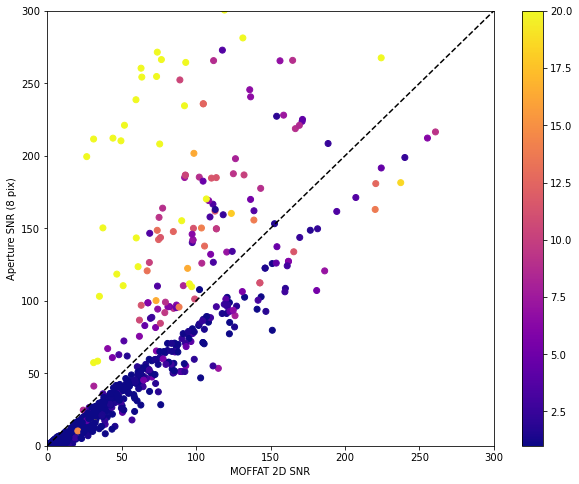

In [117]:
plt.figure(figsize=(10,8))
plt.scatter(mastercat['25um_Flux_G2D']/mastercat['25um_Flux_err_G2D'],mastercat['25um_SNR_8pix'],c=mastercat['25um_M2D_chi2'], cmap='plasma',vmin=1,vmax=20)
plt.colorbar()
plt.plot([0,300],[0,300],'k--')
plt.xlabel('MOFFAT 2D SNR')
plt.ylabel('Aperture SNR (8 pix)')
plt.xlim(0,300)
plt.ylim(0,300)

In [96]:
checksources=mastercat['25um_SNR_8pix']/(mastercat['25um_Flux_G2D']/mastercat['25um_Flux_err_G2D'])>1.0

In [97]:
cs=mastercat[checksources]

In [98]:
makeDS9reg('checksources.reg',cs,r,label='25um_SNR_4pix');

In [99]:
#checks on table quantities

In [100]:
bestsources=np.logical_and(mastercat['25ApPhot_qflag']==0,mastercat['37ApPhot_qflag']==0)
mastercat[bestsources]

SourceID,RA(J2000),DEC(J2000),25um_Flux_4pix,25um_Flux_err_4pix,25um_SNR_4pix,25um_Flux_8pix,25um_Flux_err_8pix,25um_SNR_8pix,25um_Flux_12pix,25um_Flux_err_12pix,25um_SNR_12pix,25ApRatio8_4,25ApRatio12_8,25um_Flux_M2D,25um_Flux_err_M2D,25um_M2D_chi2,25um_Flux_G2D,25um_Flux_err_G2D,25um_G2D_chi2,25um_BestModel,fwhm25,elong25,bkg_qflag25,shape_qflag25,"cutout25 [25,25]",37um_Flux_5.5pix,37um_Flux_err_5.5pix,37um_SNR_5.5pix,37um_Flux_10.5pix,37um_Flux_err_10.5pix,37um_SNR_10.5pix,37um_Flux_14pix,37um_Flux_err_14pix,37um_SNR_14pix,37ApRatio10.5_5.5,37ApRatio14_10.5,37um_Flux_M2D,37um_Flux_err_M2D,37um_M2D_chi2,37um_Flux_G2D,37um_Flux_err_G2D,37um_G2D_chi2,37um_BestModel,fwhm37,elong37,bkg_qflag37,shape_qflag37,"cutout37 [31,31]",sky_centroid,25ApPhot_qflag,25Ap_4pix_UL,25Ap_8pix_UL,25Ap_12pix_UL,37ApPhot_qflag,37Ap_5.5pix_UL,37Ap_10.5pix_UL,37Ap_14pix_UL,id
,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg",,,,,,,,,
str17,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes1,float64,float64,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes1,float64,float64,int32,int32,float64,object,int32,float64,float64,float64,int32,float64,float64,float64,int64
SFGC359.348-0.082,266.09495036354866,-29.53536811998432,1.871,0.1084,17.26,4.543,0.1906,23.83,6.375,0.291,21.9,2.428,6.375,5.172,0.1808,0.3988,--,--,--,M,2.126E-38,1,0,0,0.001117 .. 0.007079,4.119,0.2118,19.45,9.406,0.3866,24.33,12.12,0.5128,23.63,2.284,1.288,8.351,0.3089,0.2529,8.352,0.3086,0.2477,M,10.87,1.138,0,0,-0.02684 .. 0.01578,"266.09495036354866,-29.53536811998432",0,0.0,0.0,0.0,0,0.0,0.0,0.0,1
SFGC359.365-0.074,266.0976520367033,-29.5169558758474,1.772,0.0947,18.71,4.237,0.1561,27.15,5.377,0.2251,23.89,2.391,5.377,4.668,0.1425,0.346,4.611,0.1403,0.324,M,9.155,1.26,0,0,0.01011 .. -0.002261,4.36,0.2048,21.29,8.482,0.3744,22.66,8.995,0.4963,18.12,1.946,1.06,7.781,0.2845,0.3834,7.743,0.2793,0.3112,M,10.84,1.493,0,0,0.01056 .. 0.01029,"266.0976520367033,-29.5169558758474",0,0.0,0.0,0.0,0,0.0,0.0,0.0,2
SFGC359.372-0.079,266.1066587461282,-29.513297870753597,3.601,0.09096,39.59,9.078,0.1523,59.59,12.87,0.2198,58.54,2.521,12.87,10.49,0.1474,1.568,10.24,0.1404,0.7087,A,6.733,1.813,0,0,0.005548 .. 0.00861,7.148,0.2026,35.28,16.2,0.3728,43.46,20.03,0.4942,40.53,2.267,1.236,14.14,0.2989,0.7741,14.02,0.2917,0.5219,M,8.066,1.626,0,0,-0.001289 .. -0.00303,"266.1066587461282,-29.513297870753597",0,0.0,0.0,0.0,0,0.0,0.0,0.0,3
SFGC359.374-0.088,266.11699223318425,-29.51585973844053,1.869,0.09748,19.17,5.283,0.1552,34.04,7.79,0.2229,34.95,2.827,7.79,6.067,0.1505,0.4887,6.061,0.1493,0.4077,M,11.8,1.359,0,0,0.01787 .. -0.0138,6.031,0.2032,29.69,13.13,0.3713,35.35,16.02,0.4918,32.58,2.176,1.221,11.7,0.3006,0.5158,11.69,0.2966,0.3798,M,12.91,1.51,0,0,0.01259 .. -0.02276,"266.11699223318425,-29.51585973844053",0,0.0,0.0,0.0,0,0.0,0.0,0.0,4
SFGC359.376-0.094,266.12312364597364,-29.517588948087333,1.619,0.1,16.18,4.446,0.1581,28.11,6.653,0.2267,29.35,2.746,6.653,5.393,0.1514,0.9055,5.466,0.1453,0.3945,G,6.851,2.766,0,0,0.002939 .. 0.002277,4.579,0.202,22.67,10.5,0.3687,28.47,13.04,0.4883,26.7,2.292,1.242,9.047,0.2957,0.7499,9.065,0.2779,0.3056,M,6.706,4.084,0,1,-0.01079 .. 0.00555,"266.12312364597364,-29.517588948087333",0,0.0,0.0,0.0,0,0.0,0.0,0.0,5
SFGC359.408-0.024,266.0744999820003,-29.45337395736227,8.204,0.8111,10.11,15.79,1.621,9.742,18.61,2.431,7.657,1.925,18.61,16.99,1.39,0.01255,16.12,1.32,0.01325,A,5.585,1.241,0,0,-7.734E-05 .. -0.0007088,18.34,1.476,12.43,34.94,2.817,12.4,40.21,3.756,10.71,1.905,1.151,31.71,2.152,0.02075,31.52,2.133,0.01604,A,7.777,1.223,0,0,0.003928 .. -0.006673,"266.0744999820003,-29.45337395736227",0,0.0,0.0,0.0,0,0.0,0.0,0.0,9
SFGC359.410+0.032,266.02006908793686,-29.42252156100146,2.435,0.7414,3.284,6.285,1.479,4.248,9.391,2.227,4.217,2.581,9

In [101]:
poor25=mastercat['25ApPhot_qflag']==111
badsources=mastercat[poor25]
makeDS9reg('sources_25_photflag_111.reg',badsources,r,label='id');
len(badsources)

104

In [102]:
poor37=mastercat['37ApPhot_qflag']==111
badsources=mastercat[poor37]
makeDS9reg('sources_37_photflag_111.reg',badsources,r,label='id');
len(badsources)

103

In [103]:
#poor=np.logical_and(mastercat['25phot_qflag']>1,mastercat['37phot_qflag']>1)
#badsources=mastercat[poor]

In [104]:
#makeDS9reg('photflagsources.reg',badsources,r);

In [105]:
#check for negative source fluxes - replace if found or just flag?
ts=mastercat[mastercat['25um_Flux_4pix']<0]
makeDS9reg('problemsources25_4pix.reg',ts,r,color='red');
ts

SourceID,RA(J2000),DEC(J2000),25um_Flux_4pix,25um_Flux_err_4pix,25um_SNR_4pix,25um_Flux_8pix,25um_Flux_err_8pix,25um_SNR_8pix,25um_Flux_12pix,25um_Flux_err_12pix,25um_SNR_12pix,25ApRatio8_4,25ApRatio12_8,25um_Flux_M2D,25um_Flux_err_M2D,25um_M2D_chi2,25um_Flux_G2D,25um_Flux_err_G2D,25um_G2D_chi2,25um_BestModel,fwhm25,elong25,bkg_qflag25,shape_qflag25,"cutout25 [25,25]",37um_Flux_5.5pix,37um_Flux_err_5.5pix,37um_SNR_5.5pix,37um_Flux_10.5pix,37um_Flux_err_10.5pix,37um_SNR_10.5pix,37um_Flux_14pix,37um_Flux_err_14pix,37um_SNR_14pix,37ApRatio10.5_5.5,37ApRatio14_10.5,37um_Flux_M2D,37um_Flux_err_M2D,37um_M2D_chi2,37um_Flux_G2D,37um_Flux_err_G2D,37um_G2D_chi2,37um_BestModel,fwhm37,elong37,bkg_qflag37,shape_qflag37,"cutout37 [31,31]",sky_centroid,25ApPhot_qflag,25Ap_4pix_UL,25Ap_8pix_UL,25Ap_12pix_UL,37ApPhot_qflag,37Ap_5.5pix_UL,37Ap_10.5pix_UL,37Ap_14pix_UL,id
,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg",,,,,,,,,
str17,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes1,float64,float64,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes1,float64,float64,int32,int32,float64,object,int32,float64,float64,float64,int32,float64,float64,float64,int64
SFGC359.908-0.007,266.3563708470723,-29.018393257955392,-0.02279,3.311,-0.006885,-0.2953,0.5483,-0.5386,-0.5818,0.4819,-1.207,12.96,1.97,0.05866,0.04252,0.3854,0.07957,0.04767,0.3823,M,2.994,2.879,--,--,-- .. --,0.6394,0.3596,1.778,1.305,0.5261,2.48,1.123,0.7216,1.556,2.041,0.8606,1.214,0.2798,0.2464,1.142,0.2421,0.2302,M,15.02,5.16,0,1,-0.005238 .. 0.03059,"266.3563708470723,-29.018393257955392",111,9.909843614304869,1.3495733938562884,0.8639856851059335,111,1.718149350967987,2.882984441175667,3.2875696377815427,688
SFGC359.926-0.047,266.4070516747887,-29.02373968386626,-0.1132,4.804,-0.02357,-0.3605,3.02,-0.1193,2.311,0.7354,3.142,3.184,-6.411,-2.874,0.1945,4.213,-3.12,0.1981,3.984,A,15.14,2.54,--,--,-- .. --,8.425,0.3172,26.56,28.82,0.3735,77.15,54.33,0.4714,115.3,3.42,1.885,24.86,0.4365,3.339,24.69,0.2328,1.876,G,174.9,18.62,0,21,-0.005861 .. 0.3051,"266.4070516747887,-29.02373968386626",110,14.297945931496855,8.70030113898434,0.0,0,0.0,0.0,0.0,693
SFGC0.664-0.039,266.83589105284943,-28.38845008793058,-0.2047,0.3345,-0.612,0.9398,0.3997,2.351,--,--,--,-4.591,--,--,--,--,--,--,--,A,2.126E-38,1,--,--,-- .. --,14.5,0.3489,41.56,66.67,0.7857,84.85,--,--,--,4.598,--,47.89,0.6868,0.4962,--,--,--,M,2.126E-38,1,0,21,0.01354 .. --,"266.83589105284943,-28.38845008793058",110,0.7987566913209971,2.138997185406325,0.0,0,0.0,0.0,0.0,869


In [106]:
ts=mastercat[mastercat['25um_Flux_8pix']<0]
makeDS9reg('problemsources25_8pix.reg',ts,r,color='magenta');
ts

SourceID,RA(J2000),DEC(J2000),25um_Flux_4pix,25um_Flux_err_4pix,25um_SNR_4pix,25um_Flux_8pix,25um_Flux_err_8pix,25um_SNR_8pix,25um_Flux_12pix,25um_Flux_err_12pix,25um_SNR_12pix,25ApRatio8_4,25ApRatio12_8,25um_Flux_M2D,25um_Flux_err_M2D,25um_M2D_chi2,25um_Flux_G2D,25um_Flux_err_G2D,25um_G2D_chi2,25um_BestModel,fwhm25,elong25,bkg_qflag25,shape_qflag25,"cutout25 [25,25]",37um_Flux_5.5pix,37um_Flux_err_5.5pix,37um_SNR_5.5pix,37um_Flux_10.5pix,37um_Flux_err_10.5pix,37um_SNR_10.5pix,37um_Flux_14pix,37um_Flux_err_14pix,37um_SNR_14pix,37ApRatio10.5_5.5,37ApRatio14_10.5,37um_Flux_M2D,37um_Flux_err_M2D,37um_M2D_chi2,37um_Flux_G2D,37um_Flux_err_G2D,37um_G2D_chi2,37um_BestModel,fwhm37,elong37,bkg_qflag37,shape_qflag37,"cutout37 [31,31]",sky_centroid,25ApPhot_qflag,25Ap_4pix_UL,25Ap_8pix_UL,25Ap_12pix_UL,37ApPhot_qflag,37Ap_5.5pix_UL,37Ap_10.5pix_UL,37Ap_14pix_UL,id
,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg",,,,,,,,,
str17,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes1,float64,float64,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes1,float64,float64,int32,int32,float64,object,int32,float64,float64,float64,int32,float64,float64,float64,int64
SFGC359.434-0.078,266.1424582586157,-29.45998416557863,0.3374,0.2003,1.685,-0.07595,1.588,-0.04782,-0.5965,0.379,-1.574,-0.2251,7.854,0.3823,0.05531,0.2851,0.3863,0.05512,0.2805,M,2.364,1.353,0,0,-0.001477 .. 0.0007534,2.418,0.3519,6.871,7.381,0.4177,17.67,14.33,0.5152,27.81,3.052,1.941,5.892,0.263,0.527,--,--,--,M,2.126E-38,1,--,--,-- .. --,"266.1424582586157,-29.45998416557863",111,0.9381928466792295,4.689166565245717,0.5403787420000478,0,0.0,0.0,0.0,406
SFGC0.083-0.106,266.55714302499206,-28.92054823717264,0.2898,0.2349,1.234,-0.02211,5.607,-0.003942,-0.1927,0.9971,-0.1933,-0.07627,8.719,0.3339,0.06949,0.4394,0.3533,0.07235,0.4365,M,2.367,1.817,0,0,0.02049 .. 0.006246,0.9233,0.3414,2.704,2.091,0.5205,4.018,2.612,0.6676,3.912,2.265,1.249,1.712,0.3213,0.2849,1.836,0.3259,0.2725,M,5.048,2.715,--,--,-- .. --,"266.55714302499206,-28.92054823717264",111,0.9945621798419444,16.79966721942059,2.7985463907810573,100,1.9474092986556073,0.0,0.0,527
SFGC0.163-0.042,266.5424567899163,-28.819016392090024,0.6703,0.9844,0.6809,-0.9637,1.372,-0.7025,1.333,1.494,0.8922,-1.438,-1.384,0.7725,0.167,8.133,1.916,0.1634,5.881,A,3.834,11.38,0,0,0.1218 .. -0.0005469,7.34,0.3626,20.24,22.96,0.412,55.72,42.33,0.5146,82.26,3.127,1.844,18.18,0.2606,1.287,18.23,0.2608,1.222,M,12.8,1.406,--,--,-- .. --,"266.5424567899163,-28.819016392090024",111,3.6234448331928273,3.1518536827823365,5.8166211486967585,0,0.0,0.0,0.0,574
SFGC359.908-0.007,266.3563708470723,-29.018393257955392,-0.02279,3.311,-0.006885,-0.2953,0.5483,-0.5386,-0.5818,0.4819,-1.207,12.96,1.97,0.05866,0.04252,0.3854,0.07957,0.04767,0.3823,M,2.994,2.879,--,--,-- .. --,0.6394,0.3596,1.778,1.305,0.5261,2.48,1.123,0.7216,1.556,2.041,0.8606,1.214,0.2798,0.2464,1.142,0.2421,0.2302,M,15.02,5.16,0,1,-0.005238 .. 0.03059,"266.3563708470723,-29.018393257955392",111,9.909843614304869,1.3495733938562884,0.8639856851059335,111,1.718149350967987,2.882984441175667,3.2875696377815427,688
SFGC359.926-0.047,266.4070516747887,-29.02373968386626,-0.1132,4.804,-0.02357,-0.3605,3.02,-0.1193,2.311,0.7354,3.142,3.184,-6.411,-2.874,0.1945,4.213,-3.12,0.1981,3.984,A,15.14,2.54,--,--,-- .. --,8.425,0.3172,26.56,28.82,0.3735,77.15,54.33,0.4714,115.3,3.42,1.885,24.86,0.4365,3.339,24.69,0.2328,1.876,G,174.9,18.62,0,21,-0.005861 .. 0.3051,"266.4070516747887,-29.02373968386626",110,14.297945931496855,8.70030113898434,0.0,0,0.0,0.0,0.0,693
SFGC0.016+0.006,266.40892798207443,-28.919413154260667,0.03519,2.147,0.01639,-0.2389,0.6593,-0.3623,-1.03,0.3524,-2.923,-6.79,4.312,0.05575,0.02177,0.4891,0.09014,0.03308,0.4859,M,0.473,8.639,--,--,-- .. --,1.688,0.27,6.252,1.3

In [107]:
ts=mastercat[mastercat['25um_Flux_12pix']<0]
makeDS9reg('problemsources25_12pix.reg',ts,r,color='yellow');
ts

SourceID,RA(J2000),DEC(J2000),25um_Flux_4pix,25um_Flux_err_4pix,25um_SNR_4pix,25um_Flux_8pix,25um_Flux_err_8pix,25um_SNR_8pix,25um_Flux_12pix,25um_Flux_err_12pix,25um_SNR_12pix,25ApRatio8_4,25ApRatio12_8,25um_Flux_M2D,25um_Flux_err_M2D,25um_M2D_chi2,25um_Flux_G2D,25um_Flux_err_G2D,25um_G2D_chi2,25um_BestModel,fwhm25,elong25,bkg_qflag25,shape_qflag25,"cutout25 [25,25]",37um_Flux_5.5pix,37um_Flux_err_5.5pix,37um_SNR_5.5pix,37um_Flux_10.5pix,37um_Flux_err_10.5pix,37um_SNR_10.5pix,37um_Flux_14pix,37um_Flux_err_14pix,37um_SNR_14pix,37ApRatio10.5_5.5,37ApRatio14_10.5,37um_Flux_M2D,37um_Flux_err_M2D,37um_M2D_chi2,37um_Flux_G2D,37um_Flux_err_G2D,37um_G2D_chi2,37um_BestModel,fwhm37,elong37,bkg_qflag37,shape_qflag37,"cutout37 [31,31]",sky_centroid,25ApPhot_qflag,25Ap_4pix_UL,25Ap_8pix_UL,25Ap_12pix_UL,37ApPhot_qflag,37Ap_5.5pix_UL,37Ap_10.5pix_UL,37Ap_14pix_UL,id
,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg",,,,,,,,,
str17,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes1,float64,float64,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes1,float64,float64,int32,int32,float64,object,int32,float64,float64,float64,int32,float64,float64,float64,int64
SFGC0.153-0.036,266.530548636114,-28.82410395378865,1.022,0.335,3.052,0.548,1.217,0.4505,-1.1,0.9256,-1.189,0.5361,-1.1,2.306,0.1689,5.011,2.526,0.1705,4.685,A,4.208,2.549,0,20,0.05489 .. 0.03052,2.282,0.5057,4.513,3.207,0.7306,4.389,5.504,0.6904,7.973,1.405,1.716,5.923,0.2712,2.514,6.117,0.272,2.422,A,5.275,1.596,0,20,-0.00804 .. 0.009049,"266.530548636114,-28.82410395378865",11,0.0,4.1978488137732715,1.6763355766598809,0,0.0,0.0,0.0,245
SFGC0.180-0.098,266.6078134,-28.8334936,0.461,0.1866,2.47,0.1379,1.051,0.1312,-0.3299,0.7017,-0.4701,0.2992,-0.3299,0.4622,0.05271,0.3686,0.4447,0.05061,0.3671,M,2.389,1.257,0,0,-0.01844 .. -0.005646,0.8058,0.3375,2.387,0.773,0.6533,1.183,1.537,0.7119,2.159,0.9592,1.989,0.8362,0.1526,0.1812,0.826,0.1501,0.1802,M,2.839,1.2,0,0,0.0009319 .. 0.02235,"266.6078134,-28.8334936",111,1.0209125539100767,3.2920919373835185,1.775231881336747,111,1.8183978146072415,2.7329111212906247,3.6726461554388248,277
SFGC359.434-0.078,266.1424582586157,-29.45998416557863,0.3374,0.2003,1.685,-0.07595,1.588,-0.04782,-0.5965,0.379,-1.574,-0.2251,7.854,0.3823,0.05531,0.2851,0.3863,0.05512,0.2805,M,2.364,1.353,0,0,-0.001477 .. 0.0007534,2.418,0.3519,6.871,7.381,0.4177,17.67,14.33,0.5152,27.81,3.052,1.941,5.892,0.263,0.527,--,--,--,M,2.126E-38,1,--,--,-- .. --,"266.1424582586157,-29.45998416557863",111,0.9381928466792295,4.689166565245717,0.5403787420000478,0,0.0,0.0,0.0,406
SFGC359.757+0.005,266.2553826,-29.1412836,0.8143,0.1571,5.183,0.8596,0.3001,2.865,-0.009973,28.53,-0.0003495,1.056,-0.0116,0.9815,0.08897,0.4362,0.9953,0.09003,0.4368,M,4.01,1.157,0,0,-0.001631 .. -0.03858,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,A,2.126E-38,1,--,--,-- .. --,"266.2553826,-29.1412836",11,0.0,1.7597366402373564,85.5920795353605,0,0.0,0.0,0.0,436
SFGC359.955-0.031,266.4079814372357,-28.991032760887705,0.9622,0.2435,3.952,0.7,0.6297,1.112,-0.5095,1.267,-0.4021,0.7275,-0.7279,1.09,0.08909,1.208,1.407,0.1026,1.078,M,2.608,2.645,0,0,-0.000539 .. 0.02626,0.1948,5.423,0.03593,-3.454,0.7482,-4.616,-5.1,0.8068,-6.321,-17.73,1.477,2.194,0.3434,2.209,2.044,0.3075,2.186,A,3.73,2.552,--,--,-- .. --,"266.4079814372357,-28.991032760887705",11,0.0,2.589048422011248,3.2920971661456817,111,16.46261294851205,-1.2089925473958991,-2.67908817786509,478
SFGC359.958-0.029,266.40825013578797,-28.987411936338404,1.285,0.2583,4.975,0.9765,0.6472,1.509,-0.1366,6.636,-0.02058,0.7599,-0.1398,1.711,0.1139,1.307,1.863,0.1095,1.086,M,2.919,2.321,0,0,0.01991 .. 0.05987,1.484,0.8239,1.801,-0.7409,3.032,-0.2444,0.3494,8.488,0.04116,-0.4993,-0.4716,-2.338,0.2324,0.8063,--,--,--,M,2.126E-38,1,--,-

In [108]:
mastercat[mastercat['37um_Flux_5.5pix']<0]

SourceID,RA(J2000),DEC(J2000),25um_Flux_4pix,25um_Flux_err_4pix,25um_SNR_4pix,25um_Flux_8pix,25um_Flux_err_8pix,25um_SNR_8pix,25um_Flux_12pix,25um_Flux_err_12pix,25um_SNR_12pix,25ApRatio8_4,25ApRatio12_8,25um_Flux_M2D,25um_Flux_err_M2D,25um_M2D_chi2,25um_Flux_G2D,25um_Flux_err_G2D,25um_G2D_chi2,25um_BestModel,fwhm25,elong25,bkg_qflag25,shape_qflag25,"cutout25 [25,25]",37um_Flux_5.5pix,37um_Flux_err_5.5pix,37um_SNR_5.5pix,37um_Flux_10.5pix,37um_Flux_err_10.5pix,37um_SNR_10.5pix,37um_Flux_14pix,37um_Flux_err_14pix,37um_SNR_14pix,37ApRatio10.5_5.5,37ApRatio14_10.5,37um_Flux_M2D,37um_Flux_err_M2D,37um_M2D_chi2,37um_Flux_G2D,37um_Flux_err_G2D,37um_G2D_chi2,37um_BestModel,fwhm37,elong37,bkg_qflag37,shape_qflag37,"cutout37 [31,31]",sky_centroid,25ApPhot_qflag,25Ap_4pix_UL,25Ap_8pix_UL,25Ap_12pix_UL,37ApPhot_qflag,37Ap_5.5pix_UL,37Ap_10.5pix_UL,37Ap_14pix_UL,id
,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg",,,,,,,,,
str17,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes1,float64,float64,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes1,float64,float64,int32,int32,float64,object,int32,float64,float64,float64,int32,float64,float64,float64,int64
SFGC359.925+0.015,266.34523206946267,-28.992391637679,0.7013,0.1118,6.273,0.7816,0.1921,4.068,0.3909,0.4432,0.8819,1.114,0.5001,0.8712,0.06056,0.5004,0.9216,0.06119,0.4313,M,2.559,1.894,0,0,-0.004446 .. 0.004471,-0.255,0.6391,-0.399,-1.459,0.3916,-3.725,-2.284,0.4755,-4.804,5.721,1.566,-1.322,0.2285,0.3354,0.1021,0.05537,0.4399,M,2.966,3.26,--,--,-- .. --,"266.34523206946267,-28.992391637679",1,0.0,0.0,1.7205451556662923,111,1.6622875636719443,-0.28397214293291584,-0.8578747048041746,448
SFGC359.941-0.047,266.41591289251033,-29.011575486381314,17.37,0.3632,47.84,63.27,0.2429,260.5,320.5,0.2189,1464,3.641,5.065,104.9,1.782,640.6,104.6,1.66,565.2,A,25.16,2.746,3,20,0.3456 .. 0.3532,-39.45,0.4696,-84.02,-62.23,0.6252,-99.54,82.34,0.6991,117.8,1.577,-1.323,-109.5,8.413,1419,-118.7,8.149,1296,A,7.809,41.99,--,--,-- .. --,"266.41591289251033,-29.011575486381314",0,0.0,0.0,0.0,110,-38.04435724544018,-60.3573874242129,0.0,462
SFGC359.967+0.002,266.38294793306153,-28.9632480244344,0.7753,0.131,5.919,0.6562,0.2722,2.41,0.2837,0.7977,0.3557,0.8464,0.4323,0.9103,0.07386,0.5618,0.8843,0.07132,0.5553,M,3.882,1.213,0,0,0.008121 .. 0.0184,-1.157,0.321,-3.604,-2.887,0.4519,-6.388,-4.361,0.5777,-7.549,2.495,1.511,-3.051,0.2679,0.3699,-3.014,0.258,0.347,M,15.13,2.317,--,--,-- .. --,"266.38294793306153,-28.9632480244344",11,0.0,1.4729950870014603,2.6767681110776405,111,-0.19382967054603428,-1.5313153158836204,-2.6282906832362585,489
SFGC359.980+0.018,266.37576546485667,-28.94422162038458,1.007,0.2437,4.131,1.295,0.439,2.951,1.733,0.6181,2.804,1.287,1.338,1.087,0.141,0.3053,1.042,0.1352,0.3053,M,2.716,1.044,0,0,-0.02071 .. -0.02802,-0.04602,20.5,-0.002244,0.5003,3.683,0.1359,3.045,1.302,2.339,-10.87,6.085,2.641,0.3799,0.4144,2.726,0.3781,0.4016,M,5.932,14.15,--,--,-- .. --,"266.37576546485667,-28.94422162038458",11,0.0,2.6122303712044057,3.587408960328916,111,61.468772017357864,11.548645442623192,6.950282202915266,491
SFGC359.986-0.061,266.45572062611586,-28.980151187658542,1.46,0.09451,15.45,1.564,0.1618,9.668,0.909,0.2757,3.297,1.071,0.5813,1.723,0.06751,0.5161,1.734,0.06676,0.4343,M,2.991,1.479,0,0,-0.01152 .. 0.007233,-1.353,0.2272,-5.955,-7.083,0.3577,-19.8,-10.94,0.4721,-23.17,5.235,1.544,-5.739,0.2909,0.4549,0.07431,0.05435,1.8,M,2.465,2.666,--,--,-- .. --,"266.45572062611586,-28.980151187658542",0,0.0,0.0,0.0,111,-0.6714719537547458,-6.010102272361415,-9.52010977186777,495
SFGC0.040-0.056,266.48366246515945,-28.931265520024056,0.791,0.1146,6.9,1.053,0.1845,5.705,1.309,0.2508,5.219,1.331,1.244,1.048,0.0773,0.4202,1.037,0.07355,0.369,M,3.049,1.735,0,0,0.003413 .. -0.005908,-0

In [109]:
mastercat[mastercat['37um_Flux_10.5pix']<0]

SourceID,RA(J2000),DEC(J2000),25um_Flux_4pix,25um_Flux_err_4pix,25um_SNR_4pix,25um_Flux_8pix,25um_Flux_err_8pix,25um_SNR_8pix,25um_Flux_12pix,25um_Flux_err_12pix,25um_SNR_12pix,25ApRatio8_4,25ApRatio12_8,25um_Flux_M2D,25um_Flux_err_M2D,25um_M2D_chi2,25um_Flux_G2D,25um_Flux_err_G2D,25um_G2D_chi2,25um_BestModel,fwhm25,elong25,bkg_qflag25,shape_qflag25,"cutout25 [25,25]",37um_Flux_5.5pix,37um_Flux_err_5.5pix,37um_SNR_5.5pix,37um_Flux_10.5pix,37um_Flux_err_10.5pix,37um_SNR_10.5pix,37um_Flux_14pix,37um_Flux_err_14pix,37um_SNR_14pix,37ApRatio10.5_5.5,37ApRatio14_10.5,37um_Flux_M2D,37um_Flux_err_M2D,37um_M2D_chi2,37um_Flux_G2D,37um_Flux_err_G2D,37um_G2D_chi2,37um_BestModel,fwhm37,elong37,bkg_qflag37,shape_qflag37,"cutout37 [31,31]",sky_centroid,25ApPhot_qflag,25Ap_4pix_UL,25Ap_8pix_UL,25Ap_12pix_UL,37ApPhot_qflag,37Ap_5.5pix_UL,37Ap_10.5pix_UL,37Ap_14pix_UL,id
,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg",,,,,,,,,
str17,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes1,float64,float64,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes1,float64,float64,int32,int32,float64,object,int32,float64,float64,float64,int32,float64,float64,float64,int64
SFGC0.014-0.046,266.4583205912805,-28.947678772774754,1.747,0.09552,18.29,2.121,0.1626,13.04,2.081,0.2365,8.798,1.214,2.081,2.227,0.07779,0.6823,2.118,0.07104,0.4462,M,4.862,1.792,0,0,0.001298 .. -0.003853,0.7065,0.2967,2.381,-0.5026,0.6845,-0.7342,-1.924,0.5503,-3.497,-0.7114,3.829,0.7783,0.1164,0.3012,0.8053,0.1181,0.2951,M,2.411,1.54,0,0,-0.01804 .. -0.005747,"266.4583205912805,-28.947678772774754",0,0.0,0.0,0.0,111,1.5966445861234584,1.5508672080425177,-0.2737256639713994,164
SFGC0.108-0.016,266.4843717331022,-28.852471503655984,2.587,0.09466,27.33,3.927,0.1588,24.73,3.895,0.2304,16.91,1.518,3.895,4.017,0.0982,0.6057,3.894,0.09441,0.5086,M,4.216,1.326,0,0,0.01258 .. 0.003512,0.6777,0.3391,1.999,-1.197,0.4864,-2.461,-1.337,0.6239,-2.143,-1.766,1.117,1.143,0.1285,0.6703,1.331,0.1429,0.6435,M,2.688,1.774,0,0,0.0189 .. -0.0006766,"266.4843717331022,-28.852471503655984",0,0.0,0.0,0.0,111,1.6950252867447284,0.26222679859308995,0.5349415406104152,215
SFGC359.514-0.074,266.1866903832937,-29.389531429816437,0.5133,0.7759,0.6616,0.6309,1.546,0.4081,0.4988,2.324,0.2146,1.229,0.7906,0.5761,0.6225,0.002776,0.6034,0.636,0.002624,M,2.44,1.575,0,0,0.001979 .. -0.002355,0.4902,1.419,0.3454,-0.06336,4.615,-0.01373,-0.644,3.714,-0.1734,-0.1293,10.16,0.5344,1.022,0.003178,0.5255,0.9943,0.003157,M,4.282,1.4,--,--,-- .. --,"266.1866903832937,-29.389531429816437",111,2.840837819992072,5.268818421200523,7.471747115008114,111,4.74772413522493,13.782338587837158,10.49830571201193,415
SFGC359.742+0.006,266.2447233332759,-29.152908292488075,0.6393,0.1133,5.64,0.5774,0.2189,2.638,0.4055,0.4139,0.9796,0.9033,0.7022,0.6769,0.05103,0.2758,0.6756,0.05069,0.2698,M,3.328,1.256,0,0,-0.000721 .. 0.009138,0.2803,0.4552,0.6157,-0.1201,1.874,-0.06408,-0.1985,1.557,-0.1275,-0.4284,1.653,0.3814,0.09282,0.2499,0.3796,0.0912,0.2484,M,2.049,1.533,--,--,-- .. --,"266.2447233332759,-29.152908292488075",11,0.0,1.2340513083079903,1.647296694075219,111,1.6460326145924284,5.501617798522257,4.472373505954294,431
SFGC359.925+0.015,266.34523206946267,-28.992391637679,0.7013,0.1118,6.273,0.7816,0.1921,4.068,0.3909,0.4432,0.8819,1.114,0.5001,0.8712,0.06056,0.5004,0.9216,0.06119,0.4313,M,2.559,1.894,0,0,-0.004446 .. 0.004471,-0.255,0.6391,-0.399,-1.459,0.3916,-3.725,-2.284,0.4755,-4.804,5.721,1.566,-1.322,0.2285,0.3354,0.1021,0.05537,0.4399,M,2.966,3.26,--,--,-- .. --,"266.34523206946267,-28.992391637679",1,0.0,0.0,1.7205451556662923,111,1.6622875636719443,-0.28397214293291584,-0.8578747048041746,448
SFGC359.941-0.047,266.41591289251033,-29.011575486381314,17.37,0.3632,47.84,63.27,0.2429,260.5,320.5,0.2189,1464,3

In [110]:
ts2=mastercat[mastercat['37um_Flux_14pix']<0]
ts2

SourceID,RA(J2000),DEC(J2000),25um_Flux_4pix,25um_Flux_err_4pix,25um_SNR_4pix,25um_Flux_8pix,25um_Flux_err_8pix,25um_SNR_8pix,25um_Flux_12pix,25um_Flux_err_12pix,25um_SNR_12pix,25ApRatio8_4,25ApRatio12_8,25um_Flux_M2D,25um_Flux_err_M2D,25um_M2D_chi2,25um_Flux_G2D,25um_Flux_err_G2D,25um_G2D_chi2,25um_BestModel,fwhm25,elong25,bkg_qflag25,shape_qflag25,"cutout25 [25,25]",37um_Flux_5.5pix,37um_Flux_err_5.5pix,37um_SNR_5.5pix,37um_Flux_10.5pix,37um_Flux_err_10.5pix,37um_SNR_10.5pix,37um_Flux_14pix,37um_Flux_err_14pix,37um_SNR_14pix,37ApRatio10.5_5.5,37ApRatio14_10.5,37um_Flux_M2D,37um_Flux_err_M2D,37um_M2D_chi2,37um_Flux_G2D,37um_Flux_err_G2D,37um_G2D_chi2,37um_BestModel,fwhm37,elong37,bkg_qflag37,shape_qflag37,"cutout37 [31,31]",sky_centroid,25ApPhot_qflag,25Ap_4pix_UL,25Ap_8pix_UL,25Ap_12pix_UL,37ApPhot_qflag,37Ap_5.5pix_UL,37Ap_10.5pix_UL,37Ap_14pix_UL,id
,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg",,,,,,,,,
str17,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes1,float64,float64,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes1,float64,float64,int32,int32,float64,object,int32,float64,float64,float64,int32,float64,float64,float64,int64
SFGC359.442-0.102,266.1714345711507,-29.465688697659726,1.154,0.1075,10.73,0.9538,0.207,4.607,0.3093,0.6511,0.475,0.8267,0.3093,1.25,0.06521,0.4262,1.272,0.06615,0.4188,M,3.016,1.166,0,0,0.006017 .. 0.006715,2.759,0.2084,13.24,0.9444,0.5269,1.792,-1.94,0.5424,-3.576,0.3422,-2.054,2.904,0.1258,0.5135,2.986,0.1281,0.4755,M,3.948,1.301,0,0,0.00875 .. 0.008957,"266.1714345711507,-29.465688697659726",1,0.0,0.0,2.2627109114322876,11,0.0,2.524943473010413,-0.3125550226231548,31
SFGC0.014-0.046,266.4583205912805,-28.947678772774754,1.747,0.09552,18.29,2.121,0.1626,13.04,2.081,0.2365,8.798,1.214,2.081,2.227,0.07779,0.6823,2.118,0.07104,0.4462,M,4.862,1.792,0,0,0.001298 .. -0.003853,0.7065,0.2967,2.381,-0.5026,0.6845,-0.7342,-1.924,0.5503,-3.497,-0.7114,3.829,0.7783,0.1164,0.3012,0.8053,0.1181,0.2951,M,2.411,1.54,0,0,-0.01804 .. -0.005747,"266.4583205912805,-28.947678772774754",0,0.0,0.0,0.0,111,1.5966445861234584,1.5508672080425177,-0.2737256639713994,164
SFGC0.108-0.016,266.4843717331022,-28.852471503655984,2.587,0.09466,27.33,3.927,0.1588,24.73,3.895,0.2304,16.91,1.518,3.895,4.017,0.0982,0.6057,3.894,0.09441,0.5086,M,4.216,1.326,0,0,0.01258 .. 0.003512,0.6777,0.3391,1.999,-1.197,0.4864,-2.461,-1.337,0.6239,-2.143,-1.766,1.117,1.143,0.1285,0.6703,1.331,0.1429,0.6435,M,2.688,1.774,0,0,0.0189 .. -0.0006766,"266.4843717331022,-28.852471503655984",0,0.0,0.0,0.0,111,1.6950252867447284,0.26222679859308995,0.5349415406104152,215
SFGC0.190+0.036,266.48263315590583,-28.75525978718012,2.426,0.09355,25.94,3.115,0.1576,19.76,2.354,0.2355,9.994,1.284,2.354,3.147,0.07892,0.5339,2.971,0.07379,0.428,M,3.309,1.365,0,0,0.0007985 .. 0.00327,1.646,0.2374,6.934,0.5704,0.697,0.8183,-1.017,0.6791,-1.498,0.3465,-1.783,1.742,0.1623,0.2806,1.792,0.1612,0.2521,M,5.092,1.623,0,0,0.01536 .. 0.0181,"266.48263315590583,-28.75525978718012",0,0.0,0.0,0.0,11,0.0,2.661382387463872,1.0200466719960555,294
SFGC359.514-0.074,266.1866903832937,-29.389531429816437,0.5133,0.7759,0.6616,0.6309,1.546,0.4081,0.4988,2.324,0.2146,1.229,0.7906,0.5761,0.6225,0.002776,0.6034,0.636,0.002624,M,2.44,1.575,0,0,0.001979 .. -0.002355,0.4902,1.419,0.3454,-0.06336,4.615,-0.01373,-0.644,3.714,-0.1734,-0.1293,10.16,0.5344,1.022,0.003178,0.5255,0.9943,0.003157,M,4.282,1.4,--,--,-- .. --,"266.1866903832937,-29.389531429816437",111,2.840837819992072,5.268818421200523,7.471747115008114,111,4.74772413522493,13.782338587837158,10.49830571201193,415
SFGC359.620-0.049,266.2259614210343,-29.286371355804484,0.5514,0.1755,3.142,1.179,0.2333,5.051,1.81,0.31,5.839,2.138,1.536,1.442,0.1825,0.5714,1.639,0.1801,0.48,M,44.8,8.995,0,0,-0.009453 

In [111]:
#makeDS9reg('problemsources37.reg',ts2,r,label='37um_Flux_14pix');

In [112]:
makeDS9reg('ExamineErrors.reg',mastercat,r,label='25um_Flux_err_8pix');

## Optional - Create combined Segment Map Catalogs (mainly for testing purposes)

In [113]:
#create combined field segment map source catalog at 25 um
Segcat25=CombineFieldResults('segCat',25)

#Remove duplications from overlapping fields
SegCat25=remove_duplicates(Segcat25, 3.0*u.arcsec)

#lets examine SNR cuts...
snrcut4pix=SegCat25['aper_snr_4pix']>=5.0 #max snr in all computed apertures must be gtreq to 5
Segcat25snr=SegCat25[snrcut4pix] #apply snr cut
print("Number of 25 um Seg Catalog Sources after SNR cut: ", len(Segcat25snr))

#write ds9 file
makeDS9file('Segcat_4pixSNRselect_25m_NoLabel.reg', Segcat25snr, r, color='green')

#write fits file
Segcat25snr.write('SegCat_CombinedFields_snrcut.fits',overwrite=True)

Error... Must pick another file to start with


UnboundLocalError: local variable 'cat' referenced before assignment

In [ ]:
Segcat25snr

In [ ]:
#create combined field segment map source catalog at 37 um
Segcat37=CombineFieldResults('segCat',37)

#Remove duplications from overlapping fields
SegCat37=remove_duplicates(Segcat37, 3.0*u.arcsec)

#lets examine SNR cuts...
snrcut4pix=SegCat37['aper_snr_4pix']>=5.0 #max snr in all computed apertures must be gtreq to 5
Segcat37snr=SegCat37[snrcut4pix] #apply snr cut
print("Number of 37 um Seg Catalog Sources after SNR cut: ", len(Segcat37snr))

#write ds9 file
makeDS9file('Segcat_4pixSNRselect_37m_NoLabel.reg', Segcat37snr, r, color='green')

#write fits file
Segcat37snr.write('SegCat_CombinedFields_snrcut.fits',overwrite=True)

In [ ]:
Segcat37snr